In [1]:

#------------------------------------------------------------------------------------------------
#  Copyright (c) Shell Global Solutions International B.V. All rights reserved.
#  Licensed under the MIT License. See License.txt in the project root for license information.
#------------------------------------------------------------------------------------------------

# Unsteady-state drainage experiment with synthetic data - via Excel file

Inverse Modeling of Unsteady-State (USS) Core Flooding Experiments in Special Core Analysis (SCAL)
for the purpose of extracting relative permeability and capillary pressure-saturation functions
for a $\rm{CO_2}$-brine displacement process, which is drainage
                        
Created on 13.12.2024
by Steffen Berg and Daan de Kort

based on example_Fig17_USS_dpw+dpo+Swz_bumpfloods.ipynb
         example004_USS_match_using_LET_and_Skjaeveland_v001.py by Harm Dijk


* using LET model for relative permeability parameterization 
* using Skjaeveland model for capillary pressure parameterization
* match production curve, pressure drop vs. time, and saturation profiles
* include 3 "bump floods" at successively increased flow rate for better constraining solution
* generate synthetic data set in Python
* save in Excel
* read data, settings, flow schedule from Excel
* this can be modified to use actual experimental data from unsteady-state coreflooding experiments

# Dependencies

In [2]:
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

plt.rc('figure',facecolor='white')

from scallib001.displacementmodel1D2P001 import DisplacementModel1D2P
import scallib001.relpermlib001 as rlplib

## Skjaeveland pc model

In [3]:
class Skjaeveland:
    
    def __init__(self,Swc,Sorw,Swi,cw,aw,ao,si,ofs):
        
        self.Swc = Swc
        self.Sorw = Sorw
        self.Swi  = Swi
        self.cw   = cw
        self.aw   = aw
        self.ao   = ao
        self.ofs  = ofs
        
        ssw = (  Swi-Swc )/(1-Swc )
        sso = (1-Swi-Sorw)/(1-Sorw)
        co = - cw*np.power(sso,ao)/np.power(ssw,aw)
        
        self.co = co
        self.si = si
        
    def calc(self,swv):
        Swc  = self.Swc
        Sorw = self.Sorw

        sov = 1-swv
        ssw = (swv-Swc )/(1-Swc )
        sso = (sov-Sorw)/(1-Sorw)
        
        l = (swv-self.Swi) * self.si * -1
    
        return self.cw/np.power(ssw,self.aw) + self.co/np.power(sso,self.ao) + l + self.ofs

# Generate a ground truth: synthetic relperm and pc

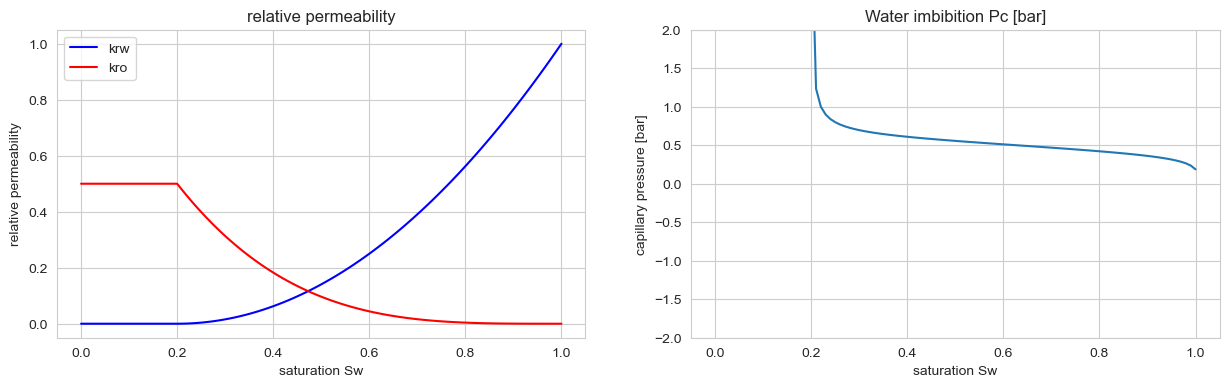

In [4]:
# relperm and pc 

KRWE = 1.0
KROE = 0.5
SWC = 0.2
SORW = 0.0
NW = 2.0
NOW = 3.5

rlp_model1 = rlplib.Rlp2PCorey( SWC, SORW, NW, NOW, KRWE, KROE )


#Define the Skjaeveland Pc model
#extended with Masalmeh linear slope, parameter 'ci'

#cpr_model1 = rlplib.CubicInterpolator( 
#    np.array([0.08,0.1,0.15,0.3,0.4,0.5,0.59,0.68,0.73,0.78,0.81,0.82,0.859,0.86]), 
#    np.array([-0.0,-0.001,-0.0054,-0.015,-0.0193,-0.0241,-0.0435,-0.0923,-0.1284,-0.18,-0.21,-0.24,-0.9,-2.0])
#    )

# make new pc model
AWI = 0.60
AOI = 0.1
CWI = 0.05
SWI  = 0.22
CI = 0.2
ofs = 1.0

Sorwi = SORW - 0.01
skj_model = Skjaeveland( SWC, Sorwi, SWI, CWI, AWI, AOI, CI, ofs )
EPS = 0.001  
n = 101
swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )
pcvi = skj_model.calc(swvi)
cpr_model1 = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )


swv = np.linspace(0,1,101)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( swv, rlp_model1.calc_kr1(swv), 'b', label='krw')
plt.plot( swv, rlp_model1.calc_kr2(swv), 'r', label='kro')
plt.legend();
plt.title('relative permeability');
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability');

plt.subplot(1,2,2)
plt.plot( swv, cpr_model1.calc(swv)[0] )
plt.ylim(-2,2)
plt.title('Water imbibition Pc [bar]');
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure [bar]');

plt.show()

# Run ground truth flow model --> generate ground truth dp and production data, Sw profiles

In [5]:
# core and fluid data

exp_core_length    = 3.9       # cm
exp_core_area      = 12.0      # cm2
exp_permeability   = 100.0     # mDarcy
exp_porosity       = 0.18      # v/v
exp_sw_initial     = 1.0       # v/v      # for primary drainage initial saturation is 1.0
exp_viscosity_w    = 1.0       # cP
exp_viscosity_n    = 1.0       # cP
exp_density_w      = 1000.0    # kg/m3
exp_density_n      = 1000.0 


# schedules

# T_End in dimensionless time
# tD_conv = (u.hour * u.cm**3/u.minute / (L*A*por)).to(u.minute/u.minute)

T_END = 2.0  # hours

# times at which saturation profiles are taken

Movie_times = np.linspace(0,T_END,100)       # 100 individual times for pressure drop and production data

# drainage = fractional flow 0.0

Schedule = pd.DataFrame( 
     [[0.0,    0.1, 0.0],
      [1.4,  2*0.1, 0.0],     # bump floods
      [1.6,  5*0.1, 0.0],
      [1.8,  10*0.1, 0.0]],    # bump floods
    columns=['StartTime','InjRate','FracFlow'] )
#times in min, injrate in cm3/min


#Define 1D2P displacement model

model1 = DisplacementModel1D2P(    
    NX=50,
    core_length    = exp_core_length,
    core_area      = exp_core_area,
    permeability   = exp_permeability,
    porosity       = exp_porosity,
    sw_initial     = exp_sw_initial,
    viscosity_w    = exp_viscosity_w,
    viscosity_n    = exp_viscosity_n,
    density_w      = exp_density_w,
    density_n      = exp_density_n,
    rlp_model      = rlp_model1,
    cpr_model      = cpr_model1,
    time_end       = T_END,
    rate_schedule  = Schedule,
    movie_schedule = Movie_times, # Same timesteps as experimental data
 )


#Solve the model with the initial gues relperm and capcurve models
#note that first time code needs to be called by numba, takes some time
model1.solve();

#Keep the results
result_exp = model1.results

#print(result_exp.keys())
#print(result_exp.tss_table.keys())

#plot model results
#1D2P timestep summary data stored in 'tss_table', with column names similar to MoReS

# Plot pressure drop, production curve and saturation profiles generated from ground truth

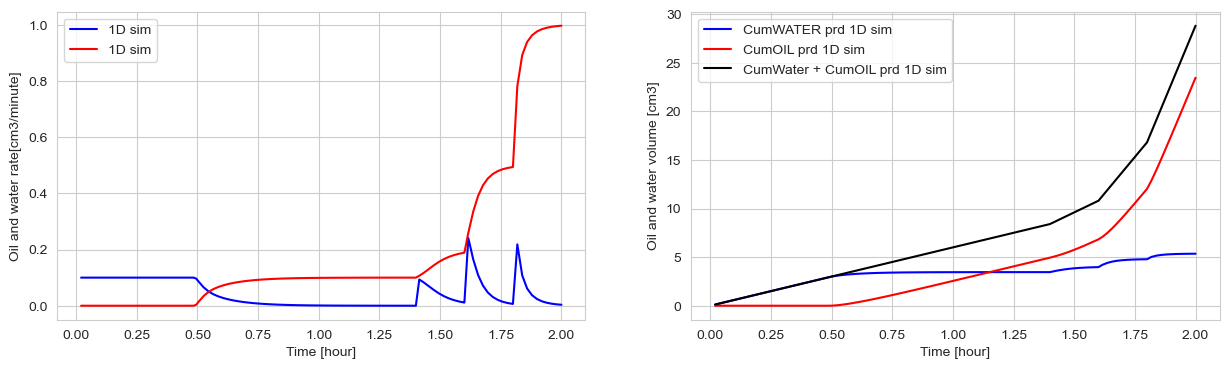

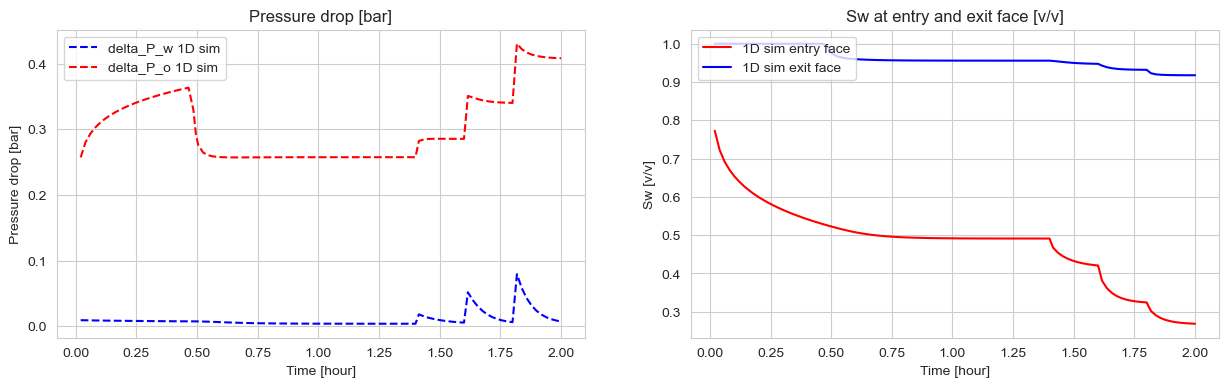

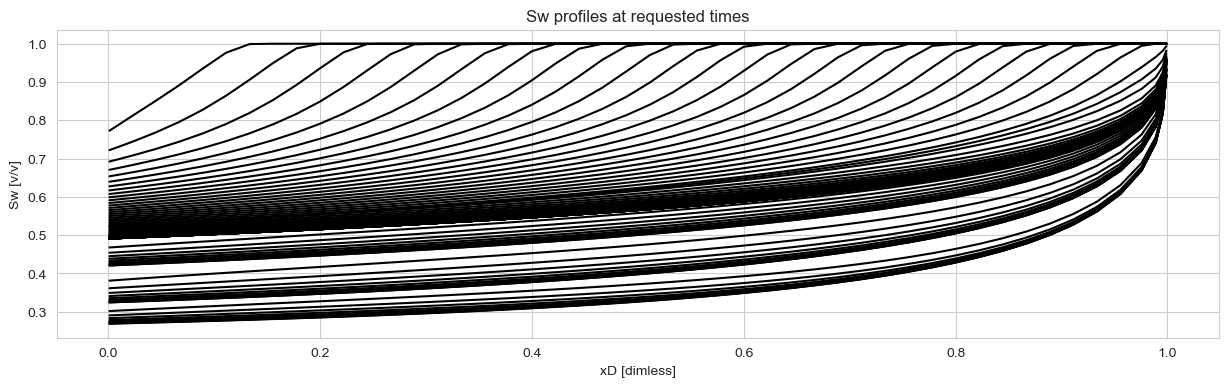

In [6]:
plt.figure(figsize=(15,4))
tss = result_exp.tss_table
plt.subplot(1,2,1)
plt.plot( tss.TIME, tss.WATERProd, 'b', label='1D sim' )
plt.plot( tss.TIME, tss.OILProd, 'r', label='1D sim' )
plt.legend();
plt.ylabel('Oil and water rate[cm3/minute]')
plt.xlabel('Time [hour]');
plt.subplot(1,2,2)
plt.plot( tss.TIME, tss.CumWATER, 'b', label='CumWATER prd 1D sim' )
plt.plot( tss.TIME, tss.CumOIL, 'r', label='CumOIL prd 1D sim' )
plt.plot( tss.TIME, tss.CumWATER+tss.CumOIL, 'black', label='CumWater + CumOIL prd 1D sim' )
plt.legend();
plt.ylabel('Oil and water volume [cm3]')
plt.xlabel('Time [hour]');
plt.show()


plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
tss = result_exp.tss_table
plt.plot( tss.TIME, tss.delta_P_w,'b--', label='delta_P_w 1D sim')
plt.plot( tss.TIME, tss.delta_P_o,'r--', label='delta_P_o 1D sim' );
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop [bar]')
plt.legend(loc='upper left');
plt.subplot(1,2,2)
plt.plot( result_exp.movie_time, result_exp.movie_sw[:, 0],'r',   label='1D sim entry face')
plt.plot( result_exp.movie_time, result_exp.movie_sw[:,-1],'b',   label='1D sim exit face' )
plt.legend(loc='upper left');
plt.title('Sw at entry and exit face [v/v]')
plt.xlabel('Time [hour]');
plt.ylabel('Sw [v/v]');
plt.show()

plt.figure(figsize=(15,4))
plt.plot( result_exp.xD, result_exp.movie_sw.T, 'k');
plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Sw profiles at requested times');
plt.show()

# "Experimental data" = ground truth with noise added

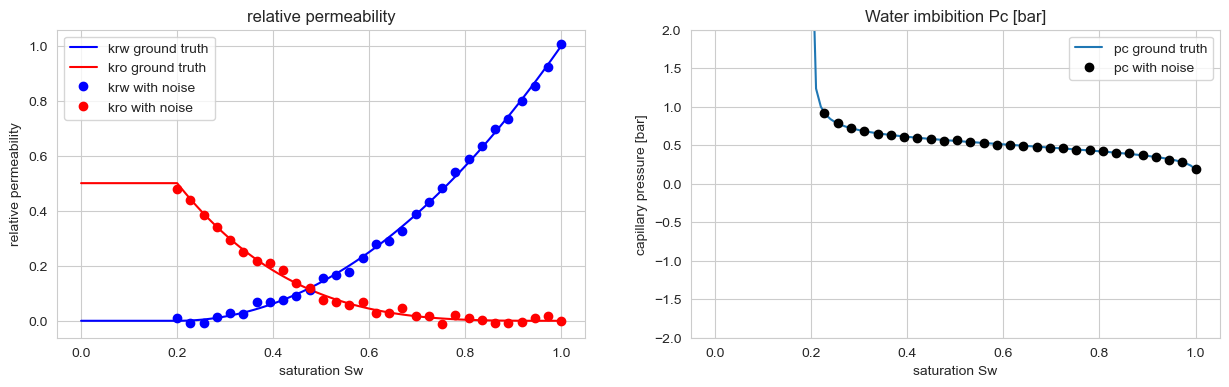

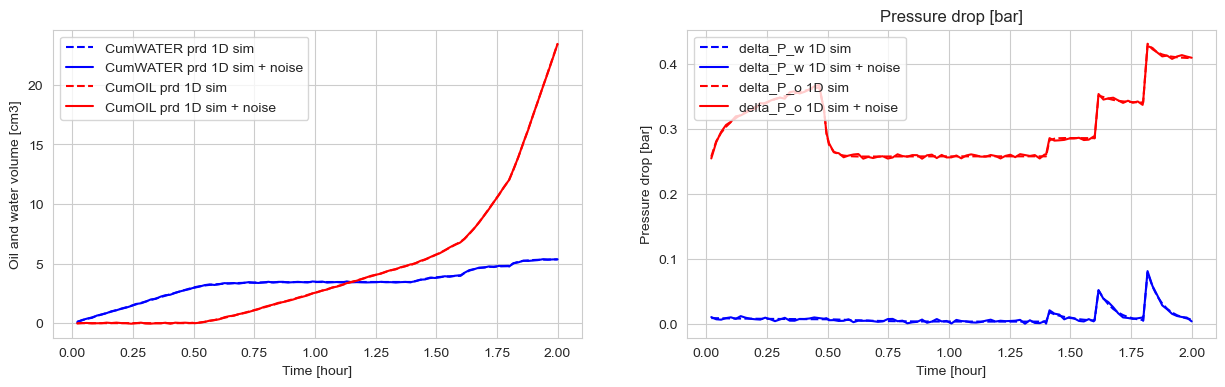

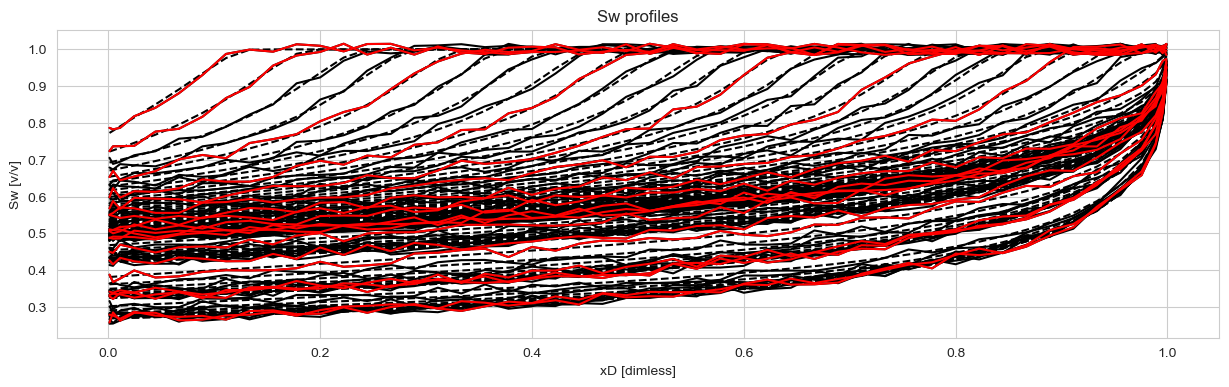

In [7]:
# add noise to relperm and pc models (starting values for fit)
Nkr=2*15   # number of relperm data points
swvNkr = np.linspace(SWC,1-SORW,Nkr)
Indexv=np.linspace(1,Nkr,Nkr)

krerrlevel=0.05   # add 10% noise
np.random.seed(123)
krexpdata={'INDEX':Indexv,'Sat':swvNkr,'kr1':(rlp_model1.calc_kr1(swvNkr)+krerrlevel*(np.random.rand(Nkr)-0.5)),'kr2':(rlp_model1.calc_kr2(swvNkr)+krerrlevel*(np.random.rand(Nkr)-0.5))}
krexp=pd.DataFrame(data=krexpdata)

pcerrlevel=0.1*krerrlevel*np.abs(cpr_model1.calc(swvNkr)[0]).max()
#pcexpdata=krexpdata={'INDEX':Indexv,'Sat':swvNkr,'Pc':(cpr_model1.calc(swvNkr)[0]+pcerrlevel*(np.random.rand(Nkr)-0.5))}
pcexpdata=krexpdata={'INDEX':Indexv,'Sat':swvNkr,'Pc':(cpr_model1.calc(swvNkr)[0]+pcerrlevel*(np.random.rand(Nkr)-0.5))}
pcexp=pd.DataFrame(data=pcexpdata)

swv = np.linspace(0,1,101)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( swv, rlp_model1.calc_kr1(swv), 'b', label='krw ground truth')
plt.plot( swv, rlp_model1.calc_kr2(swv), 'r', label='kro ground truth')
plt.plot( krexp.Sat, krexp.kr1, 'o', color='blue', label='krw with noise')
plt.plot( krexp.Sat, krexp.kr2, 'o', color='red', label='kro with noise')
plt.legend();
plt.title('relative permeability');
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability');

plt.subplot(1,2,2)
plt.plot( swv, cpr_model1.calc(swv)[0], label='pc ground truth')
plt.plot( pcexp.Sat, pcexp.Pc, 'o', color='black', label='pc with noise')
plt.ylim(-2,2)
plt.title('Water imbibition Pc [bar]');
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure [bar]');
plt.legend();
plt.show()



# add some noise to "experimental data"
Nrandt  = len(result_exp.tss_table)
Nrandx = len(result_exp.xD)

errlevel=0.05   # add 5% noise
dpmean= (tss.delta_P_w.mean()+tss.delta_P_o.mean())/2
Cummean = (tss.CumWATER.mean()+tss.CumOIL.mean())/2
Swmean = result_exp.movie_sw.T.mean()

np.random.seed(123)
dpwerr = tss.delta_P_w + dpmean*errlevel*(np.random.rand(Nrandt)-0.5)
dpoerr = tss.delta_P_o + dpmean*errlevel*(np.random.rand(Nrandt)-0.5)

CumWATERerr = tss.CumWATER + 0.5*Cummean*errlevel*(np.random.rand(Nrandt)-0.5)
CumOILerr = tss.CumOIL + 0.5*Cummean*errlevel*(np.random.rand(Nrandt)-0.5)


# this works but adds same error to each time step at same position which is a bit artificial
#Swproferr = result_exp.movie_sw.T + Swmean * errlevel * (np.random.rand(Nrandx)-0.5)[:,np.newaxis]

Swerrmaxtrix=np.full_like(result_exp.movie_sw.T,1)
for i in range(0,result_exp.movie_sw.T.shape[1]):
   Swerrmaxtrix[:,i]=Swmean * errlevel * (np.random.rand(Nrandx)-0.5)
Swproferr = result_exp.movie_sw.T+Swerrmaxtrix
Swaverr = np.average(Swproferr,axis=0)


plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( tss.TIME, tss.CumWATER, 'b--', label='CumWATER prd 1D sim' )
plt.plot( tss.TIME, CumWATERerr, 'b', label='CumWATER prd 1D sim + noise' )
plt.plot( tss.TIME, tss.CumOIL, 'r--', label='CumOIL prd 1D sim' )
plt.plot( tss.TIME, CumOILerr, 'r', label='CumOIL prd 1D sim + noise' )
plt.legend();
plt.ylabel('Oil and water volume [cm3]')
plt.xlabel('Time [hour]');
plt.subplot(1,2,2)
tss = result_exp.tss_table
plt.plot( tss.TIME, tss.delta_P_w,'b--', label='delta_P_w 1D sim')
plt.plot( tss.TIME, dpwerr,'b', label='delta_P_w 1D sim + noise')
plt.plot( tss.TIME, tss.delta_P_o,'r--', label='delta_P_o 1D sim' );
plt.plot( tss.TIME, dpoerr,'r', label='delta_P_o 1D sim + noise' );
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop [bar]')
plt.legend(loc='upper left');
plt.show()


# writing to expdataHIS data frame

# expdataHIS = result_exp.tss_table     # without noise

#with noise

Indext=np.linspace(1,Nrandt,Nrandt)
OIIP=exp_core_length*exp_core_area*exp_porosity*(1-exp_sw_initial)

# Defnition of dp_switch_time
# dp_sim = np.where( dp_time<dp_switch_time, dp_o_sim, dp_w_sim )
#dperr=dpwerr    # dp_switch_time = 0 --> dp= dp_w
dperr=dpoerr    # dp_switch_time = 0 --> dp= dp_w      # for drainage it shoudl be the oil pressure drop



#expdataHISdata={'INDEX':Indext,'TIME':tss.TIME, 'PVinj':tss.PVinj, 'Sw':Swaverr, 'RF':(CumOILerr/OIIP), 'CumOIL':CumOILerr, 'DeltaPressure':dperr, 'dpw':dpwerr, 'dpo':dpoerr, 'tD':result_exp.tss_table.tD}
expdataHISdata={'INDEX':Indext,'TIME':tss.TIME, 'PVinj':tss.PVinj, 'CumWATER':CumWATERerr, 'DeltaPressure':dperr}
expdataHIS=pd.DataFrame(data=expdataHISdata)


# Saturation profiles 

sattimelist = [0,1,4,8,12,16,20,24,28,36,50,60,72,80,82,86,90,92,98,99]     # experimental saturation profiles = subset of movie times

expdataHISsattimes = tss.TIME[sattimelist]                                  # this is the list of times at which saturation profiles are taken which will be used for the match
Indexsat=np.linspace(1,len(expdataHISsattimes),len(expdataHISsattimes))
expdataHISsattimesdata={'INDEX':Indexsat,'TIME':tss.TIME[sattimelist]}
expdataHISsattimesdf=pd.DataFrame(data=expdataHISsattimesdata)              # make data frame for later export

satprofileindex = np.linspace(1,len(result_exp.xD),len(result_exp.xD))
expdataHISsatprofilesdata = {'INDEX':satprofileindex, 'Distance':result_exp.xD * exp_core_length, 'xD':result_exp.xD}
for i in range(len(expdataHISsattimes)):                                              
    expdataHISsatprofilesdata['Profile'+str(i+1)]=Swproferr[:,sattimelist[i]]                 # experimental data = simulation profiles at movie times with noise
expdataHISsatprofiles=pd.DataFrame(data=expdataHISsatprofilesdata)          # this is what will be used for the match

#print(expdataHISsatprofiles)
#print(expdataHISsatprofiles.keys())

# plot saturation profiles at selected times

plt.figure(figsize=(15,4))
plt.plot( result_exp.xD, result_exp.movie_sw.T, 'k--',label='synthetic profiles');
plt.plot( result_exp.xD, Swproferr, 'k',label='synthetic profiles with noise');

for c in expdataHISsatprofiles.columns:
    if c.startswith('Profile'):
      plt.plot( expdataHISsatprofiles.xD, expdataHISsatprofiles[c].values, 'r-',label='considered for match');

#plt.legend()
plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Sw profiles');
plt.show()


## exporting synthetic data into Excel 

In [8]:
# write into one single Excel file as individual sheets
# using the pd.to_excel function built-in to pandas

# import openpyxl module 
import openpyxl 

filename = "expdataHISUSSdrainage.xlsx"

writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
workbook=writer.book

# basic data


# core and fluid data

basicdata = {'exp_core_length':[exp_core_length],
             'exp_core_area':[exp_core_area],
             'exp_permeability':[exp_permeability],
             'exp_porosity':[exp_porosity],
             'exp_sw_initial':[exp_sw_initial],
             'exp_viscosity_w':[exp_viscosity_w],
             'exp_viscosity_n':[exp_viscosity_n],
             'exp_density_w':[exp_density_w],
             'exp_density_n':[exp_density_n],
             'T_END':[T_END]}

basicdatapd=pd.DataFrame(data=basicdata)
worksheet=workbook.add_worksheet('basicdata')
writer.sheets['basicdata'] = worksheet
basicdatapd.to_excel(writer, sheet_name='basicdata', index=False)    

# pc curve
# pcexp.Sat, pcexp.Pc, index=False)    # this writes the data to individual XLSX files
worksheet=workbook.add_worksheet('PcSw')
writer.sheets['PcSw'] = worksheet
pcexp.to_excel(writer, sheet_name='PcSw', index=False)    

# kr guess
worksheet=workbook.add_worksheet('kr')
writer.sheets['kr'] = worksheet
krexp.to_excel(writer, sheet_name='kr', index=False)

# flow schedule
worksheet=workbook.add_worksheet('schedule')
writer.sheets['schedule'] = worksheet
Schedule.to_excel(writer, sheet_name='schedule', index=False)    


# time, dp, prod oil 
worksheet=workbook.add_worksheet('proddp')
writer.sheets['proddp'] = worksheet
expdataHIS.to_excel(writer, sheet_name='proddp', index=False)    


# Sw profiles times 
worksheet=workbook.add_worksheet('Swprofiletimes')
writer.sheets['Swprofiletimes'] = worksheet
expdataHISsattimesdf.to_excel(writer, sheet_name='Swprofiletimes', index=False) 

# Sw profiles
worksheet=workbook.add_worksheet('Swprofiles')
writer.sheets['Swprofiles'] = worksheet
expdataHISsatprofiles.to_excel(writer, sheet_name='Swprofiles', index=False)


writer.close()

## Reading data and settings back from Excel file

In [9]:
# filename = "expdataHISUSSdrainage.xlsx"


# basic data

basicdatapd1 = pd.read_excel(filename, sheet_name='basicdata')

exp_core_length    =  basicdatapd1['exp_core_length'][0] 
exp_core_area      =  basicdatapd1['exp_core_area'][0]
exp_permeability   =  basicdatapd1['exp_permeability'][0]
exp_porosity       =  basicdatapd1['exp_porosity'][0]
exp_sw_initial     =  basicdatapd1['exp_sw_initial'][0]
exp_viscosity_w    =  basicdatapd1['exp_viscosity_w'][0]
exp_viscosity_n    =  basicdatapd1['exp_viscosity_n'][0]
exp_density_w      =  basicdatapd1['exp_density_w'][0]
exp_density_n      =  basicdatapd1['exp_density_n'][0]
T_END              =  basicdatapd1['T_END'][0]


# PcSw
pcexp = pd.read_excel(filename, sheet_name='PcSw')

# kr guess
krexp = pd.read_excel(filename, sheet_name='kr')

# schedule
Schedule = pd.read_excel(filename, sheet_name='schedule')

# time, dp, prod oil
expdataHIS = pd.read_excel(filename, sheet_name='proddp')

# Sw profiles times
expdataHISsattimesdf = pd.read_excel(filename, sheet_name='Swprofiletimes')
expdataHISsattimes=expdataHISsattimesdf['TIME'].values

# Sw profiles
expdataHISsatprofiles = pd.read_excel(filename, sheet_name='Swprofiles')


## plot production data, saturation profiles, kr, pc from Excel file

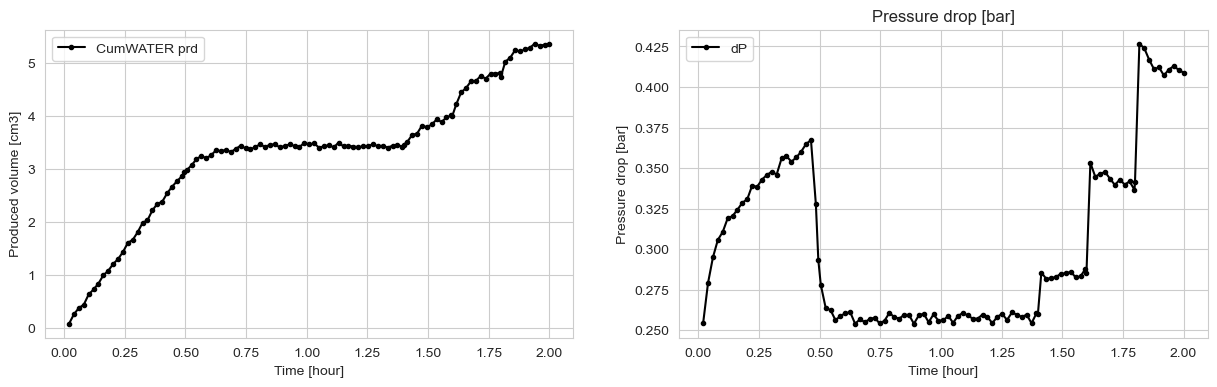

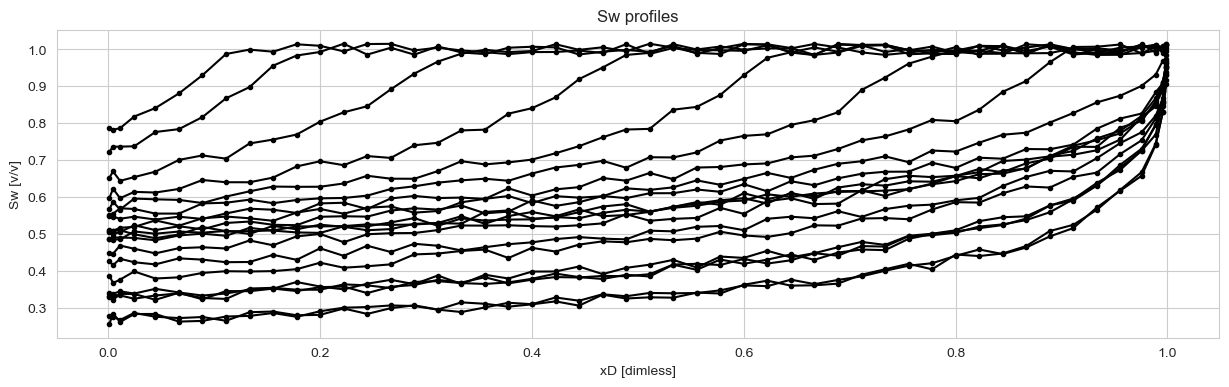

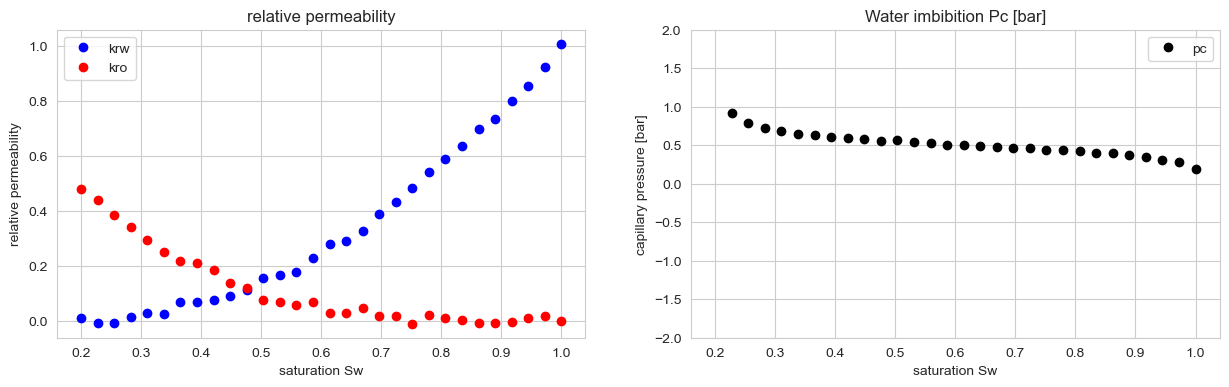

In [10]:
# production curve and dp

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( expdataHIS.TIME, expdataHIS.CumWATER, '.-', color='black', label='CumWATER prd' )
#plt.plot( expdataHIS.TIME, expdataHIS.CumOIL, '.-', color='black', label='CumOIL prd' )
plt.legend();
plt.ylabel('Produced volume [cm3]')
plt.xlabel('Time [hour]');
plt.subplot(1,2,2)
plt.plot( expdataHIS.TIME, expdataHIS.DeltaPressure,'.-', color='black', label='dP')
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop [bar]')
plt.legend(loc='upper left');
plt.show()


# saturation profiles 

plt.figure(figsize=(15,4))
for c in expdataHISsatprofiles.columns:
    if c.startswith('Profile'):
      plt.plot( expdataHISsatprofiles.xD, expdataHISsatprofiles[c].values, '.-', color='black', label='considered for match');
#plt.legend()
plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Sw profiles');
plt.show()


# kr and pc

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( krexp.Sat, krexp.kr1, 'o', color='blue', label='krw')
plt.plot( krexp.Sat, krexp.kr2, 'o', color='red', label='kro')
plt.legend();
plt.title('relative permeability');
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability');

plt.subplot(1,2,2)
plt.plot( pcexp.Sat, pcexp.Pc, 'o', color='black', label='pc')
plt.ylim(-2,2)
plt.title('Water imbibition Pc [bar]');
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure [bar]');
plt.legend();
plt.show()

# Relperm starting values: Fit LET function to tabulated relperm initial guess

In [11]:
#Fit LET model to the estimate from the experimental data
#to have starting point for fitting of USS experiment below

from lmfit import Minimizer, Parameters, report_fit

class RlpMatchObjective1:

    def __init__(self, kr_data ):

        self.kr_data = kr_data
        
        self.sw_data = kr_data.Sat.values
        self.kw_data = kr_data.kr1.values
        self.ko_data = kr_data.kr2.values

        self.errorbar = 0.02
        
        self.counter = 0

    def __call__(self, params):
        '''This function is called by the optimizer; calculate mismatch vector.'''
        
        self.counter += 1

        # Build new relperm model from current parameters
        rlpmodeli = self.params_to_rlpmodel( params )
         
        # Calculate relperm values at data sw values    
        kw, ko, _, _ = rlpmodeli.calc(self.sw_data)

        y      = np.hstack( [kw,           ko          ] ) 
        y_data = np.hstack( [self.kw_data, self.ko_data] )
        
        return (y-y_data)/self.errorbar

    def params_to_rlpmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        krwe = v['krwe']
        kroe = v['kroe']
        Lw   = v['Lw']
        Ew   = v['Ew']
        Tw   = v['Tw']
        Lo   = v['Lo']
        Eo   = v['Eo']
        To   = v['To']

        rlpmodel = rlplib.Rlp2PLET( Swc, Sorw, Lw, Ew, Tw, 
                                    Lo, Eo, To, krwe, kroe)
        
        return rlpmodel
    


print("Experimental data kr")    
print(krexp)


KRWE = krexp.kr1.max()
KROE = krexp.kr2.max()
SWC  = krexp.Sat.min()
SORW = 1-krexp.Sat.max()
NW   = 2.5
NOW  = 3.0

params_LET = Parameters()
params_LET.add('Swc',  value=SWC,  vary=False)
params_LET.add('Sorw', value=SORW, min=0.0, max=0.45, vary=True)
params_LET.add('krwe', value=KRWE, min=0.05, max=1.10, vary=True)
params_LET.add('kroe', value=KROE, min=0.05, max=1.10, vary=True)
params_LET.add('Lw', value=NW,   min=1.5,  max=5.0, vary=True)
params_LET.add('Ew', value=0.01, min=1e-4, max=50.0, vary=True)
params_LET.add('Tw', value=1.50, min=1.0,  max=5.0, vary=True)
params_LET.add('Lo', value=NOW,  min=1.5,  max=5.0, vary=True)
params_LET.add('Eo', value=0.01, min=1e-4, max=50.0, vary=True)
params_LET.add('To', value=1.50, min=1.0,  max=5.0, vary=True)

Kr_data = krexp
rlpmatchobjective1 = RlpMatchObjective1( Kr_data )

# Check that match objective function works
rlpmatchobjective1( params_LET )

result_LET = Minimizer(rlpmatchobjective1, params_LET ).least_squares(diff_step=1e-4,verbose=2)

# for making the iteration stop earlier add ftol=1e-4
#result_LET = Minimizer(rlpmatchobjective1, params_LET ).least_squares(diff_step=1e-4,verbose=2,ftol=1e-4)

Experimental data kr
    INDEX       Sat       kr1       kr2
0       1  0.200000  0.009823  0.479605
1       2  0.227586 -0.009504  0.438897
2       3  0.255172 -0.008901  0.385902
3       4  0.282759  0.013267  0.340864
4       5  0.310345  0.029998  0.293709
5       6  0.337931  0.025882  0.248433
6       7  0.365517  0.066844  0.218456
7       8  0.393103  0.067505  0.209802
8       9  0.420690  0.075146  0.183772
9      10  0.448276  0.090920  0.136293
10     11  0.475862  0.111065  0.120017
11     12  0.503448  0.155329  0.074977
12     13  0.531034  0.168153  0.067981
13     14  0.558621  0.178935  0.058114
14     15  0.586207  0.227958  0.068077
15     16  0.613793  0.279438  0.026609
16     17  0.641379  0.288524  0.029308
17     18  0.668966  0.327411  0.047066
18     19  0.696552  0.386833  0.017780
19     20  0.724138  0.430842  0.017683
20     21  0.751724  0.482344 -0.010643
21     22  0.779310  0.541847  0.021830
22     23  0.806897  0.586728  0.008608
23     24  0.834483

In [12]:
# print parameters from fit of LET model to relperm guess
report_fit(result_LET)

print('Fitting LET function to kr guess')
result_LET.params.pretty_print()

rlpmodel_LET_fit = rlpmatchobjective1.params_to_rlpmodel( result_LET.params ) 

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 181
    # data points      = 60
    # variables        = 9
    chi-square         = 18.2944840
    reduced chi-square = 0.35871537
    Akaike info crit   = -53.2646981
    Bayesian info crit = -34.4155970
##  Warning: uncertainties could not be estimated:
    Sorw:  at boundary
    Tw:    at boundary
    To:    at boundary
[[Variables]]
    Swc:   0.2 (fixed)
    Sorw:  1.7987e-14 (init = 0)
    krwe:  0.99103605 (init = 1.006549)
    kroe:  0.48169274 (init = 0.4796052)
    Lw:    1.69561886 (init = 2.5)
    Ew:    1.85380692 (init = 0.01)
    Tw:    1.00000000 (init = 1.5)
    Lo:    2.67681167 (init = 3)
    Eo:    2.97432753 (init = 0.01)
    To:    1.00000020 (init = 1.5)
Fitting LET function to kr guess
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Eo       2.974   0.0001       50     None     True     None     None
Ew       1.854   0.0001       50     None     True     Non

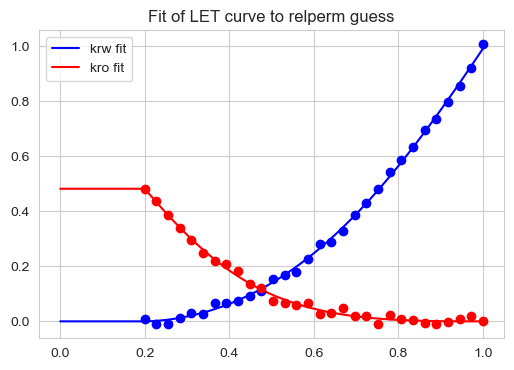

In [13]:
# Plot fit of LET model to relperm guess

swv = np.linspace(0,1,101)
plt.figure(figsize=(6,4))
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo')
plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro');
plt.legend();
plt.title('Fit of LET curve to relperm guess');
plt.show()

## Capillary Pressure: Fit Skjaeveland function to tabulated pc

In [14]:
class CPRMatchObjective1:

    def __init__(self, cpr_data ):

        self.cpr_data = cpr_data
        
        self.sw_data = cpr_data.Sat.values
        self.pc_data = cpr_data.Pc.values
        

        self.errorbar = 0.02
        
        self.counter = 0

    def __call__(self, params):
        '''This function is called by the optimizer; calculate mismatch vector.'''
        
        self.counter += 1

        # Build new pc model from current parameters
        cprmodeli = self.params_to_cprmodel( params )
         
        # Calculate pc values at data sw values    
        #pc, _, _ = cprmodeli.calc(self.sw_data)
        pc = cprmodeli.calc(self.sw_data)

        y      = pc # or use log10
        y_data = self.pc_data # or use log10
        
        return (y-y_data)/self.errorbar

    def params_to_cprmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        Swi  = v['Swi']
        cwi  = v['cwi']
        awi  = v['awi']
        aoi  = v['aoi']
        ci   = v['ci']
        ofs  = v['ofs']
        
        # We take Sorw for Pc to the right of the relperm Sorw
        Sorwi = Sorw - 0.01
        
        skj_model = Skjaeveland( Swc, Sorwi, Swi, cwi, awi, aoi, ci, ofs )

        # We give the Skjaevland Pc model to the simulator as a cubic interpolation model
        EPS = 0.001
    
        n = 101

        swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )

        pcvi = skj_model.calc(swvi)

        cpr_model = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )

        return cpr_model
    


print("Experimental data pc")    
print(pcexp)


# SWC  = pcexp.Sat.min()
SWC = 0.2
SORW = 0.0

AWI = 0.60
AOI = 0.1
CWI = 0.05
SWI  = 0.22
CI = 0.2
ofs = 1.0

params_pc = Parameters()
params_pc.add('Swc',  value=SWC,  min=0.01, max=0.3, vary=False)
params_pc.add('Sorw', value=SORW, min=SORW*0.99, max=SORW*1.01+0.001, vary=True)
params_pc.add('Swi',  value=SWI,  min=SWI*0.99, max=SWI*1.01, vary=True)
params_pc.add('cwi',   value=CWI,  min=CWI*0.99, max=CWI*1.01, vary=True)
params_pc.add('awi',   value=AWI,  min=AWI*0.99, max=AWI*1.01, vary=True)
params_pc.add('aoi',   value=AOI,  min=AOI*0.99, max=AOI*1.01, vary=True)
params_pc.add('ci',   value=CI,  min=CI*0.99, max=CI*1.01+0.0001, vary=True)
params_pc.add('ofs',   value=ofs,  min=ofs*0.9, max=ofs*1.1, vary=True)


pc_data = pcexp
cprmatchobjective1 = CPRMatchObjective1( pc_data )

# Check that match objective function works
cprmatchobjective1( params_pc )

result_CPR = Minimizer(cprmatchobjective1, params_pc,nan_policy = 'omit' ).least_squares(diff_step=1e-4,verbose=2)

report_fit(result_CPR)

print('Fitting Skjaeveland function to tabulated pc')
result_CPR.params.pretty_print()

CPRmodel_fit = cprmatchobjective1.params_to_cprmodel( result_CPR.params ) 

Experimental data pc
    INDEX       Sat        Pc
0       1  0.200000  3.560926
1       2  0.227586  0.919217
2       3  0.255172  0.784561
3       4  0.282759  0.724494
4       5  0.310345  0.689253
5       6  0.337931  0.647799
6       7  0.365517  0.637559
7       8  0.393103  0.609377
8       9  0.420690  0.591798
9      10  0.448276  0.583358
10     11  0.475862  0.560790
11     12  0.503448  0.561527
12     13  0.531034  0.544184
13     14  0.558621  0.533536
14     15  0.586207  0.508858
15     16  0.613793  0.507203
16     17  0.641379  0.494647
17     18  0.668966  0.475647
18     19  0.696552  0.463489
19     20  0.724138  0.460855
20     21  0.751724  0.441519
21     22  0.779310  0.435029
22     23  0.806897  0.418764
23     24  0.834483  0.401048
24     25  0.862069  0.394453
25     26  0.889655  0.374820
26     27  0.917241  0.344858
27     28  0.944828  0.312207
28     29  0.972414  0.277010
29     30  1.000000  0.185009
   Iteration     Total nfev        Cost      Cost

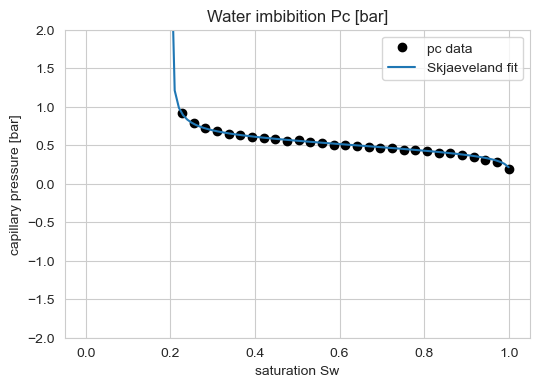

In [15]:
# plot tabulated pc data and Skjaeveland fit

swv = np.linspace(0,1,101)

plt.figure(figsize=(6,4))
plt.plot( pcexp.Sat, pcexp.Pc,'o', color='black', label='pc data')
plt.plot( swv, CPRmodel_fit.calc(swv)[0], label='Skjaeveland fit' )
plt.ylim(-2,2)
plt.title('Water imbibition Pc [bar]');
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure [bar]');
plt.legend()
plt.show()

## Check if model runs with fitted kr and pc

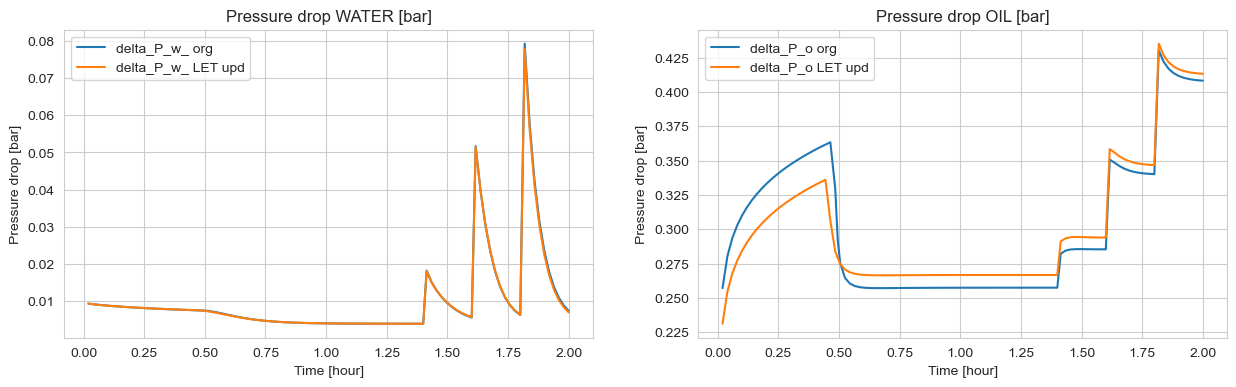

In [16]:
# Check whether the fitted kr model runs and compare with ground truth
# Assign LET relperm model to 1D2P and solve again

model1.rlp_model = rlpmodel_LET_fit
model1.cpr_model = CPRmodel_fit

result_upd1 = model1.solve().results

tss1 = result_exp.tss_table
tss2 = result_upd1.tss_table

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( tss1.TIME, tss1.delta_P_w,'-', label='delta_P_w_ org')
plt.plot( tss2.TIME, tss2.delta_P_w,'-', label='delta_P_w_ LET upd')
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop WATER [bar]')
plt.legend(loc='upper left');
plt.subplot(1,2,2)
plt.plot( tss1.TIME, tss1.delta_P_o,'-',   label='delta_P_o org')
plt.plot( tss2.TIME, tss2.delta_P_o,'-',   label='delta_P_o LET upd' );
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop OIL [bar]')
plt.legend(loc='upper left');
plt.show()

## USS Match Objective Function

In [17]:
#Define USS match objective function
#match pressure drop and Sw profiles
#switch from oil to water pressure at dp_switch_time
#weigh pressure drop vs saturation data

class USSMatchObjective1:

    def __init__(self, 
                 model, 
                 dp_weight=1, op_weight=1, sw_weight=1,
                 dp_data=None, dp_error=None, 
                 dp_switch_time = 0,

                 op_data=None, op_error=None,
                 
                 sw_profile_times=None, 
                 sw_profile_data=None, sw_error=None,

                ):

        self.model = model
        
        self.dp_weight = dp_weight
        self.dp_data   = dp_data
        self.dp_error  = dp_error
       
        self.dp_switch_time = dp_switch_time
        
        self.op_weight = op_weight
        self.op_data   = op_data
        self.op_error  = op_error
        
        self.sw_weight        = sw_weight
        self.sw_profile_times = sw_profile_times
        self.sw_profile_data  = sw_profile_data
        self.sw_error = sw_error
        
        self.counter = 0

    def __call__(self, params):
        '''This function is called by the optimizer; calculate mismatch vector.'''
        
        self.counter += 1

        # Build new relperm model from current parameters
        rlpmodeli = self.params_to_rlpmodel( params )
 
        # Build new capillary model from current parameters
        cprmodeli = self.params_to_cprmodel( params )

        model = self.model
        
        model.rlp_model = rlpmodeli
        model.cpr_model = cprmodeli
        
        results = model.solve().results
        
        
        
        tss = results.tss_table
        
        #--- Pressure match
        
        # Interpolate simulation to measurement TIME
        dp_time = self.dp_data.TIME.values
        
        dp_w_sim = np.interp( dp_time, tss.TIME.values, tss.delta_P_w.values )
        dp_o_sim = np.interp( dp_time, tss.TIME.values, tss.delta_P_o.values )
        
        
        
        # this is for USS experiments where only the total dp is measured        
        dp_switch_time = self.dp_switch_time
        #dp_sim = np.where( dp_time<dp_switch_time, dp_o_sim, dp_w_sim )    # this is for imbibition
        dp_sim = np.where( dp_time<dp_switch_time, dp_w_sim, dp_o_sim )     # this is for drainage
        dp_dat = self.dp_data.DeltaPressure.values                         ###delta_P_w.values  # ???
        dp_mismatch = (dp_sim - dp_dat) / self.dp_error
               
        # this is for Digital Rock simulations where we have both dpw and dpo  
        #dpw_dat = self.dp_data.dpw.values 
        #dpo_dat = self.dp_data.dpo.values 
        #dp_mismatch = (dp_w_sim - dpw_dat) / self.dp_error + (dp_o_sim - dpo_dat) / self.dp_error
        
        
        #--- production match                     
        # oil production                                  # this is for imbibition
        #op_time = self.op_data.TIME.values
        #op_dat  = self.op_data.CumOIL.values
        
        #op_sim = np.interp( op_time, tss.TIME.values, tss.CumOIL.values )
        
        #op_mismatch = (op_sim-op_dat)/self.op_error
        
        # water production                               # this is for drainage
        op_time = self.op_data.TIME.values
        op_dat  = self.op_data.CumWATER.values
        
        op_sim = np.interp( op_time, tss.TIME.values, tss.CumWATER.values )
        
        op_mismatch = (op_sim-op_dat)/self.op_error
 


        
        #--- Saturation profile match 
        sw_time = self.sw_profile_times
        
        xD, sw_dat, sw_sim = get_his_sim_profiles( sw_time, 
                                                   self.sw_profile_data, 
                                                   results )
        
        sw_mismatch = (sw_sim - sw_dat) / self.sw_error
        
        
        
        # ---- add up different mismatch contributions 
        
        mismatch = []
        
        dp_weight = self.dp_weight
        mismatch.append( dp_mismatch.flatten() * dp_weight )
        
        op_weight = self.op_weight
        mismatch.append( op_mismatch.flatten() * op_weight )
        
        sw_weight = self.sw_weight
        mismatch.append( sw_mismatch.flatten() * sw_weight )
            
        mismatch = np.hstack( mismatch )
        
        # Keep current state for debugging purposes
        class dictn(dict):
            def __getattr__(self,k):
                return self[k]
            
        self.current = dictn(locals())
        
        return mismatch

    def params_to_rlpmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        krwe = v['krwe']
        kroe = v['kroe']
        Lw   = v['Lw']
        Ew   = v['Ew']
        Tw   = v['Tw']
        Lo   = v['Lo']
        Eo   = v['Eo']
        To   = v['To']

        rlp_model = rlplib.Rlp2PLET( Swc, Sorw, Lw, Ew, Tw, 
                                     Lo, Eo, To, krwe, kroe)
        
        return rlp_model

    def params_to_cprmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        Swi  = v['Swi']
        cwi  = v['cwi']
        awi  = v['awi']
        aoi  = v['aoi']
        ci   = v['ci']
        ofs  = v['ofs']
        
        # We take Sorw for Pc to the right of the relperm Sorw
        Sorwi = Sorw - 0.01
        
        skj_model = Skjaeveland( Swc, Sorwi, Swi, cwi, awi, aoi, ci, ofs )

        # We give the Skjaevland Pc model to the simulator as a cubic interpolation model
        EPS = 0.001
    
        n = 101

        swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )

        pcvi = skj_model.calc(swvi)

        cpr_model = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )

        return cpr_model
    
    
#Some procedures to facilate comparison of Sw profiles model-data, used in objective function
def get_his_sw_profiles( sw_profile_data ):

    #profhis = sw_profile_data[:-1]  # drop last row, 
    profhis = sw_profile_data
    
    xpos_his = profhis.xD.values
    
    sw_his = []
    for c in profhis.columns:
        if c.startswith('Profile'):
            sw_his.append( profhis[c].values.copy() )
    sw_his = np.array( sw_his )
    
    return xpos_his, sw_his

def get_sim_sw_profiles( model_result, his_profile_times, his_xD_position ):
    
    model_xD    = model_result.xD
    movie_time  = model_result.movie_time 
    movie_sw    = model_result.movie_sw
    
    # Identify which movie index corresponds to historical sample time
    time_index = [np.argmin( np.abs(v-movie_time) ) for v in his_profile_times]
    
    # Interpolate simulation sw at data position for each sample time
    sw_sim = []
    for i in time_index:
        swi = np.interp( his_xD_position, model_xD, movie_sw[i] )
        sw_sim.append(swi)   
    sw_sim = np.array( sw_sim )
    
    return sw_sim    
    
def get_his_sim_profiles( sw_profile_times, sw_profile_data, model_result ):
    
    xpos_his, sw_his = get_his_sw_profiles( sw_profile_data )
    
    # get simulated sw profiles at data sample locations and data sample times
    sw_sim = get_sim_sw_profiles( model_result, sw_profile_times, xpos_his )
    
    return xpos_his, sw_his, sw_sim


#Define some analysis plots for match quality

def plot_rlp_cpr(matchobj, suptitle, params=None ):
    
    swv = np.linspace(0,1,101)

    if params is None:
        current_rlp_model = matchobj.current.rlpmodeli
        current_cpr_model = matchobj.current.cprmodeli
    else:
        current_rlp_model = matchobj.params_to_rlpmodel( params )
        current_cpr_model = matchobj.params_to_cprmodel( params )

    plt.figure(figsize=(15,4))

    plt.suptitle( suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    # plt.plot( swv, rlp_model1.calc_kr1(swv), label='krw start' )
    # plt.plot( swv, rlp_model1.calc_kr2(swv), label='kro start' )

    plt.plot( krexp.Sat, krexp.kr1, 'ko', label='krw start table' )
    plt.plot( krexp.Sat, krexp.kr2, 'ko', label='kro start table')

    plt.plot( swv, current_rlp_model.calc_kr1(swv), 'b--', label='krw match')
    plt.plot( swv, current_rlp_model.calc_kr2(swv), 'r--', label='kro match')

    plt.legend(loc='best')
    
    plt.title('Water and oil relperm')

    plt.subplot(1,2,2)
    # plt.plot( swv, cpr_model1.calc(swv)[0], label='Pc start' )       

    plt.plot( pcexp.Sat, pcexp.Pc, 'ko', label='Pc start table');

    swv_max = pcexp.Sat.max() + 0.01
    
    plt.plot( swv[swv<swv_max], current_cpr_model.calc(swv[swv<swv_max])[0], 'b--', label='Pc match' )

    plt.legend(loc='best')
    plt.ylim(-2,2)
    plt.title('Water imbibition Pc [bar]');
    plt.show()

       
def plot_match_dp(matchobj,suptitle, draw_phase_pressures=False):
        
    current = matchobj.current
    
    tss = current.results.tss_table

    plt.figure(figsize=(15,4))

    plt.suptitle(suptitle, fontsize=16 )
        
    plt.subplot(1,2,1)
    #plt.plot( current.dp_time, current.dp_sim, 'r', label='match')
    plt.plot( current.dp_time, current.dp_dat, 'k', alpha=0.4, label='data')
    #plt.plot( current.dp_time, current.dpw_dat, 'b-', label='dP water exp')
    #plt.plot( current.dp_time, current.dpo_dat, 'r-', label='dP oil exp')

    if draw_phase_pressures:
        plt.plot( tss.TIME, tss.delta_P_w, 'b--', label='dP water sim')
        plt.plot( tss.TIME, tss.delta_P_o, 'r--', label='dP oil sim')
    
    plt.legend(loc='best')
    plt.title('Pressure drop [bar]')
    plt.ylabel('Delta P[bar]')
    plt.xlabel('Time [hour]')
    
    plt.subplot(1,2,2)
    plt.title('Water + Oil Pressure drop standardized mismatch: (sim-data)/stderr')
    plt.plot( current.dp_time, current.dp_mismatch, color='black')
    plt.axhline(+1,color='k',ls='--')
    plt.axhline(-1,color='k',ls='--');
    
    plt.xlabel('Time [hour]');
    plt.show()

    
def plot_xplot(matchobj,suptitle):
    
    current = matchobj.current
    
    plt.figure(figsize=(15,6))
    
    plt.suptitle(suptitle, fontsize=16)

    plt.subplot(1,2,1)
    plt.plot( current.dp_dat, current.dp_sim, '.')
    plt.plot( [0,0.5], [0,.5], 'k--')
    plt.xlabel('Delta P experiment [bar]')
    plt.ylabel('Delta P sim [bar]')
    plt.title('Delta P x-plot');

    plt.subplot(1,2,2)
    plt.plot( current.sw_dat.flatten(), current.sw_sim.flatten(), '.')
    plt.plot( [0,1], [0,1], 'k--');
    plt.xlabel('Sw profile experiment [v/v]')
    plt.ylabel('Sw profile sim [v/v]');
    plt.title('Sw x-plot');
    plt.show()
    

def plot_error_press(matchobj,suptitle):
    
    current = matchobj.current
    
    
    npts = len(current.mismatch)
    
    plt.figure(figsize=(15,4))

    plt.suptitle( suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    plt.title('Water + Oil Pressure drop standardized mismatch: (sim-data)/stderr')
    plt.plot( current.dp_time, current.dp_mismatch )
    plt.axhline(-1,color='k',ls='--')
    plt.axhline(+1,color='k',ls='--')

    plt.xlabel('Time [hour]')
 
    plt.subplot(1,2,2)
    plt.title('Pressure drop cumulative mismatch SSQ')
    plt.plot( current.dp_time, np.cumsum( (current.dp_mismatch)**2)/npts )
    plt.axhline(+1,color='k',ls='--')
    plt.xlabel('Time [hour]');
    plt.show()
    

def plot_error_production(matchobj,suptitle):
    
    current = matchobj.current 
    
    npts = len(current.mismatch)
    
    plt.figure(figsize=(15,4))

    plt.suptitle( suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    plt.title('Production standardized mismatch: (sim-data)/stderr')
    plt.plot( current.op_time, current.op_mismatch )
    plt.axhline(-1,color='k',ls='--')
    plt.axhline(+1,color='k',ls='--')

    plt.xlabel('Time [hour]')
 
    plt.subplot(1,2,2)
    plt.title('Production cumulative mismatch SSQ')
    plt.plot( current.op_time, np.cumsum( (current.op_mismatch)**2)/npts )
    plt.axhline(+1,color='k',ls='--')
    plt.xlabel('Time [hour]');
    plt.show()
    
    
def plot_error_sw_profile(matchobj,suptitle):
    
    current = matchobj.current
    
    
    npts = len(current.mismatch)
    
    ntime,nx = current.sw_mismatch.shape
    
    xD_all = np.tile( current.xD, ntime )
    sw_mismatch_all = current.sw_mismatch.flatten(order='C')
    
    dummy = np.arange(sw_mismatch_all.size)
       
    xedges = np.array( [v*nx for v in np.arange(ntime+1)] )
    xmid   = (xedges[1:] + xedges[:-1])*0.5

    plt.figure(figsize=(15,8))

    plt.suptitle( suptitle )
    
    plt.subplot(2,1,1)
    
    
    plt.title('Sw profile standardized mismatch: (sim-data)/stderr')
    plt.plot( dummy, sw_mismatch_all )
    
    for v in xedges:
        plt.axvline(v,color='k',ls='--',lw=1,alpha=0.4)       
    plt.xticks(xmid)
    plt.gca().set_xticklabels( np.arange(ntime)+1 )

    plt.axhline(-1,color='k',ls='--')
    plt.axhline(+1,color='k',ls='--')

    plt.xlabel('xD [dimless] for each flow period')
    plt.ylabel('Mismatch [dimless]')
    
    plt.subplot(2,1,2)
    plt.title('Sw profile cumulative mismatch SSQ')
    plt.plot( dummy, np.cumsum( (sw_mismatch_all)**2)/npts )

    for v in xedges:
        plt.axvline(v,color='k',ls='--',lw=1,alpha=0.4)       
    plt.xticks(xmid)
    plt.gca().set_xticklabels( np.arange(ntime)+1 )
    
    plt.axhline(+1,color='k',ls='--')
    plt.xlabel('Position & Time [hour]');
    plt.ylabel('Cumulative SSQ');
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    
def plot_match_sw_profile(matchobj,suptitle):
    
    current = matchobj.current
    
    plt.figure(figsize=(14,12))

    plt.suptitle(suptitle,fontsize=16)
    
    counter=1

    for sws,swh in zip( current.sw_sim, current.sw_dat):

        plt.subplot(4,4,counter); counter+=1

        plt.plot( current.xD, sws, 'r')
        plt.plot( current.xD, swh, 'k.')
        
        plt.ylim(0,1)
        
        if counter>len(current.sw_sim)-4+1:
            plt.xlabel('xD [-]')
            
        if plt.gca().is_first_col():
            plt.ylabel('Sw [v/v]');
        
        # TODO generalize time
        v = current.sw_time[counter-2]
        plt.title('Sw at %7.3f hour'%v)

    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    
def plot_match_dp_production(uss_matchobj,suptitle,draw_phase_pressures=True):
    current = uss_matchobj.current
    
    tss = current.results.tss_table

    plt.figure(figsize=(15,4))

    plt.suptitle(suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    #plt.plot( current.dp_time, current.dp_sim, 'r', label='match')
    plt.plot( current.dp_time, current.dp_dat, 'k', alpha=0.4, label='data')
    #plt.plot( current.dp_time, current.dpw_dat, 'b-', label='dP water exp')
    #plt.plot( current.dp_time, current.dpo_dat, 'r-', label='dP oil exp')

    if draw_phase_pressures:
        plt.plot( tss.TIME, tss.delta_P_w, 'b--', label='dP water sim')
        plt.plot( tss.TIME, tss.delta_P_o, 'r--', label='dP oil sim')
    
    plt.legend(loc='best')
    plt.title('Pressure drop [bar]')
    plt.ylabel('Delta P[bar]')
    plt.xlabel('Time [hour]')
    
    plt.subplot(1,2,2)
    plt.title('Production')
    plt.plot( current.op_time, current.op_dat, 'k-', label='data')
    plt.plot( current.op_time, current.op_sim, 'r--', label='match')
    plt.xlabel('Time [hour]');   
    plt.ylabel('Production [cm3]')
    plt.show()
    

def plot_match_production(uss_matchobj,suptitle):
    
    current = uss_matchobj.current
    
    tss = current.results.tss_table

    plt.figure(figsize=(15,4))

    plt.suptitle(suptitle, fontsize=16 )
        
    plt.subplot(1,2,1)
    plt.title('Production')
    plt.plot( current.op_time, current.op_dat, 'k-', label='data')
    plt.plot( current.op_time, current.op_sim, 'r--', label='match')
    plt.xlabel('Time [hour]');   
    plt.ylabel('Production [cm3]')
    
    plt.subplot(1,2,2)
    
    plt.plot( current.op_time, current.op_mismatch, 'r' )
    plt.title('Production standardized mismatch: (sim-data)/stderr')
    plt.plot( current.op_time, current.op_mismatch, 'r')
    plt.axhline(+1,color='k',ls='--')
    plt.axhline(-1,color='k',ls='--');
    
    plt.xlabel('Time [hour]');
    plt.show()
    
    
def plot_match_all(matchobj,suptitle):
    
    plot_rlp_cpr( matchobj, suptitle )
    plt.show()
    plot_match_dp( matchobj, suptitle, draw_phase_pressures=True )
    plt.show()
    plot_error_press( matchobj, suptitle )
    plt.show()
    plot_error_sw_profile(matchobj, suptitle )
    plt.show()
    plot_xplot( matchobj, suptitle )
    plt.show()
    plot_match_sw_profile( matchobj, suptitle )
    plt.show()
    
    
def plot_match_all_uss(matchobj,suptitle):
    
    plot_rlp_cpr( matchobj, suptitle )
    plt.show()
    plot_match_dp_production( matchobj, suptitle)
    plt.show()
    plot_match_dp( matchobj, suptitle, draw_phase_pressures=True )
    plt.show()
    plot_error_press( matchobj, suptitle )
    plt.show()
    plot_match_production(matchobj, suptitle )
    plt.show()
    plot_error_production( matchobj, suptitle )
    plt.show()
    plt.show()
    plot_xplot( matchobj, suptitle )
    plt.show()

# print starting values for fit parameters

Swc 0.2 -inf inf False
Sorw 1.7986741984006092e-14 0.0 0.45 True
krwe 0.991036047924471 0.05 1.1 True
kroe 0.48169274038723536 0.05 1.1 True
Lw 1.6956188583757414 1.5 5.0 True
Ew 1.8538069211265569 0.0001 50.0 True
Tw 1.0000000000009877 1.0 5.0 True
Lo 2.6768116687788104 1.5 5.0 True
Eo 2.974327531466784 0.0001 50.0 True
To 1.0000001984491877 1.0 5.0 True
Swc 0.2 0.01 0.3 False
Sorw 1.927395185070801e-18 0.0 0.001 True
Swi 0.22219999994591408 0.2178 0.2222 True
cwi 0.049500000000002785 0.0495 0.0505 True
awi 0.5940000000042043 0.594 0.606 True
aoi 0.09900000002202876 0.099 0.101 True
ci 0.19800000000303902 0.198 0.2021 True
ofs 0.9591774580077997 0.9 1.1 True
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Eo       2.974   0.0001       50     None     True     None     None
Ew       1.854   0.0001       50     None     True     None     None
Lo       2.677      1.5        5     None     True     None     None
Lw       1.696      1.5        5     None     True    

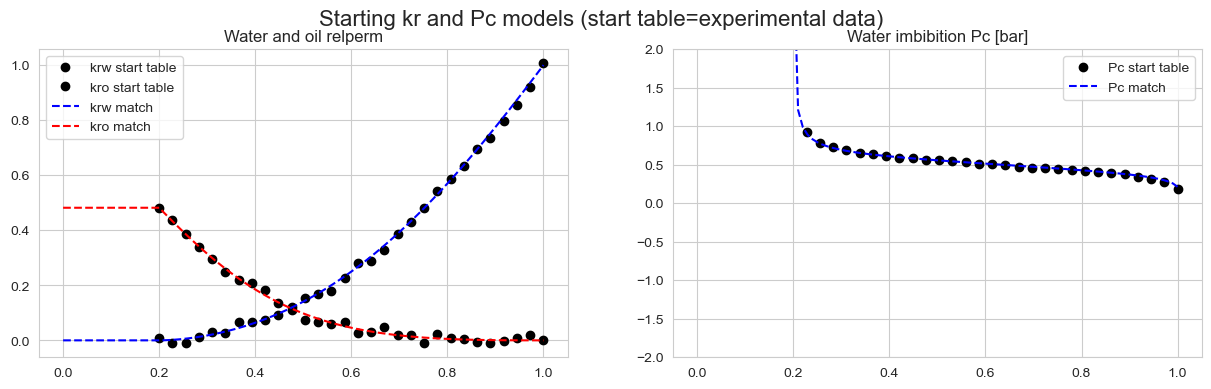

In [18]:
    
#Define match parameters for kr and Pc
    
params_pckr = Parameters()

# copy the parameter from the LET model fit to starting experimental data table data

for p in result_LET.params.values():
    print(p.name,p.value,p.min,p.max,p.vary)
    params_pckr.add(p.name,value=p.value,min=p.min,max=p.max,vary=p.vary)

# copy the parameter from the Skjaeveland model fit to tabulated pc data

for p in result_CPR.params.values():
    print(p.name,p.value,p.min,p.max,p.vary)
    params_pckr.add(p.name,value=p.value,min=p.min,max=p.max,vary=p.vary)   

params_pckr.pretty_print()

#fix Ew, Eo, Tw, To
params_pckr['Ew'].vary=False
params_pckr['Eo'].vary=False
params_pckr['Tw'].vary=False
params_pckr['To'].vary=False

# fix krwe and Sorw
params_pckr['Sorw'].value=0.0
params_pckr['Sorw'].vary=False

params_pckr['krwe'].value=1.0
params_pckr['krwe'].vary=False

# vary Swc
params_pckr['Swc'].value=SWC
params_pckr['Swc'].vary=True

# Limits for the parameters

params_pckr['Sorw'].min=0.0
params_pckr['Sorw'].max=0.1

params_pckr['Swc'].min=params_pckr['Swc'].value*0.1
params_pckr['Swc'].max=params_pckr['Swc'].value+.2

params_pckr['Swi'].min=params_pckr['Swc'].value+0.001
params_pckr['Swi'].max=params_pckr['Swc'].max

params_pckr['cwi'].min=0.01
params_pckr['cwi'].max=0.2

params_pckr['awi'].min=0.01
params_pckr['awi'].max=1.0

params_pckr['aoi'].min=0.01
params_pckr['aoi'].max=1.0

params_pckr['ci'].min=0.01
params_pckr['ci'].max=1.0

params_pckr['ofs'].min=0
params_pckr['ofs'].max=2
#params_pckr['ofs'].vary=False


#Define match objective to match both dp and sw
#switch from oil pressure to water pressure at 46.4 hour
#equal weight to dp and sw

uss_matchobj = USSMatchObjective1( 
    model=model1,
    dp_weight=1, op_weight=1, sw_weight=1,
    dp_data=expdataHIS,
    dp_error=0.01,
    op_data =expdataHIS, 
    op_error = 0.05,
    sw_profile_times=expdataHISsattimes,
    sw_profile_data =expdataHISsatprofiles,
    sw_error = 0.01,
    dp_switch_time=0, # switch from delta_P_w to delta_P_o at this time 
)


#Check that objective function works

uss_matchobj( params_pckr )


#Check starting relperm and capillary pressure model vs experimental data tables

plot_rlp_cpr( uss_matchobj, 'Starting kr and Pc models (start table=experimental data)', params=params_pckr)

# Execute fit

In [19]:

#Excute fit
#result_pckr = Minimizer(uss_matchobj, params_pckr ).least_squares(diff_step=1e-4,verbose=2)

result_pckr = Minimizer(uss_matchobj, params_pckr ).least_squares(diff_step=1e-4,verbose=2, ftol=1e-5)
#result_pckr = Minimizer(uss_matchobj, params_pckr ).least_squares(diff_step=1e-10,verbose=2, xtol=1e-10, ftol=1e-10)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.1612e+02                                    1.30e+04    
       1              2         5.2973e+02      3.86e+02       2.57e-01       3.60e+04    
       2              3         4.6591e+02      6.38e+01       1.16e-01       5.74e+02    
       3              4         4.6294e+02      2.97e+00       3.73e-02       9.62e+02    
       4              5         4.6244e+02      4.98e-01       1.73e-02       3.95e+01    
       5              7         4.6208e+02      3.66e-01       4.89e-02       1.55e+02    
       6              9         4.6158e+02      4.95e-01       2.82e-02       8.62e+01    
       7             10         4.6141e+02      1.78e-01       5.76e-02       3.01e+02    
       8             11         4.6068e+02      7.27e-01       1.02e-02       9.47e+01    
       9             12         4.6042e+02      2.59e-01       3.12e-02       2.28e+02    

# Print table with fit results

In [20]:
from lmfit import conf_interval, conf_interval2d, report_ci

# write error report
print('\n\n\n')
report_fit(result_pckr)


# print parameters from model fit

result_pckr.params.pretty_print()


#Evaluate objective at best point

uss_matchobj( result_pckr.params );





[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 323
    # data points      = 1206
    # variables        = 10
    chi-square         = 912.790745
    reduced chi-square = 0.76320296
    Akaike info crit   = -315.940608
    Bayesian info crit = -264.989965
[[Variables]]
    Swc:   0.20986200 +/- 0.04761922 (22.69%) (init = 0.2)
    Sorw:  0 (fixed)
    krwe:  1 (fixed)
    kroe:  0.47613878 +/- 0.10767461 (22.61%) (init = 0.4816927)
    Lw:    1.53086500 +/- 0.27093233 (17.70%) (init = 1.695619)
    Ew:    1.853807 (fixed)
    Tw:    1 (fixed)
    Lo:    2.89200414 +/- 0.03041378 (1.05%) (init = 2.676812)
    Eo:    2.974328 (fixed)
    To:    1 (fixed)
    Swi:   0.39994307 +/- 0.11633370 (29.09%) (init = 0.2222)
    cwi:   0.01918192 +/- 0.03436550 (179.16%) (init = 0.0495)
    awi:   0.81285505 +/- 0.76958630 (94.68%) (init = 0.594)
    aoi:   0.33980806 +/- 0.08525441 (25.09%) (init = 0.099)
    ci:    0.33471590 +/- 0.04886255 (14.60%) (init =

# Make Plots

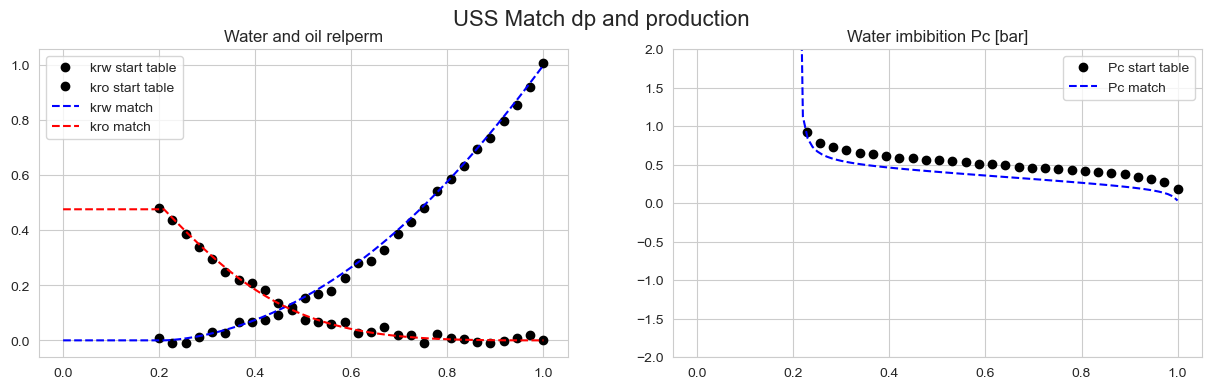

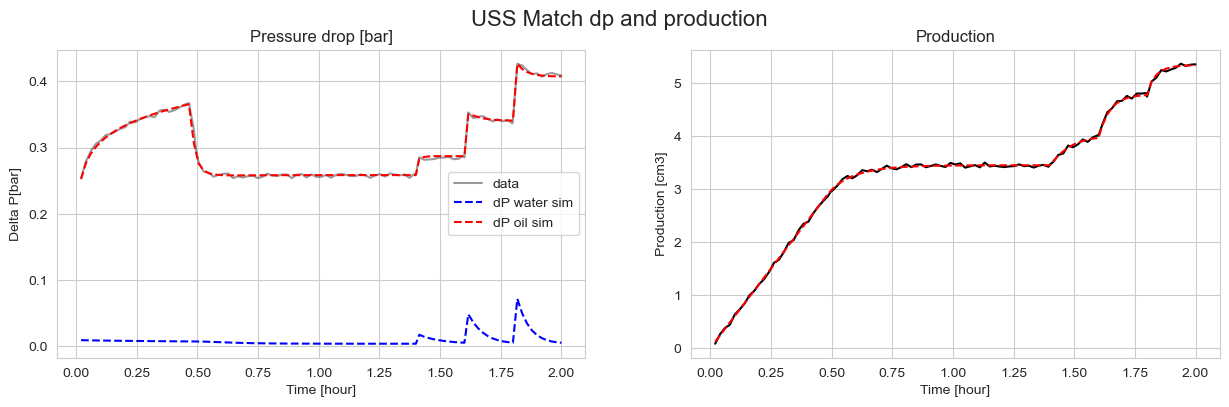

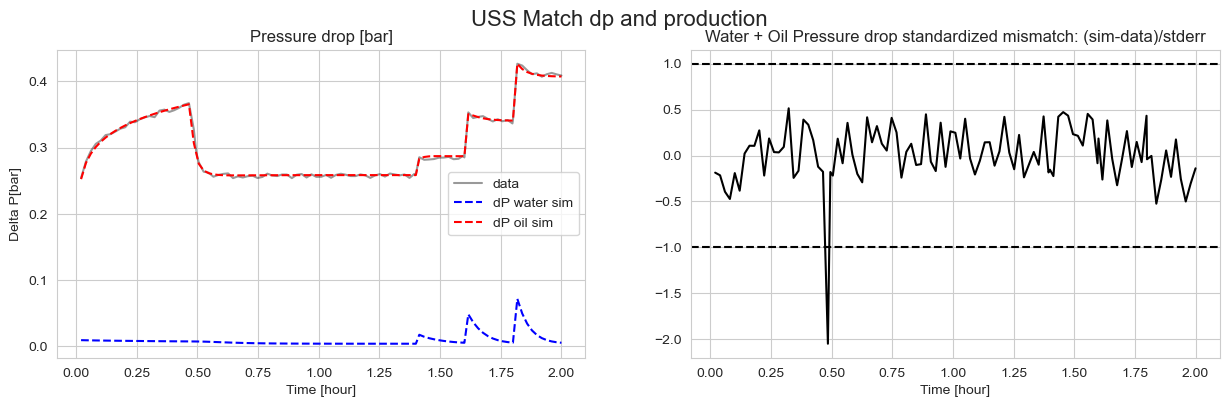

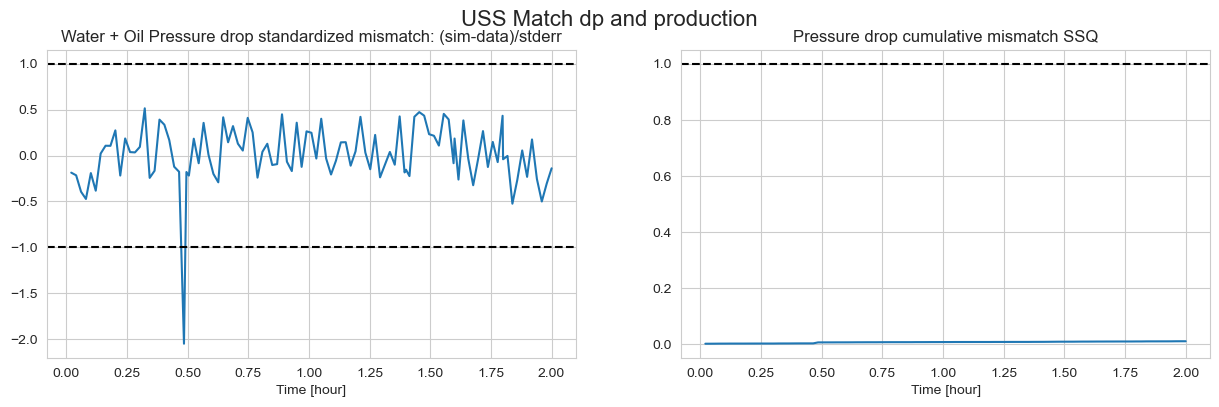

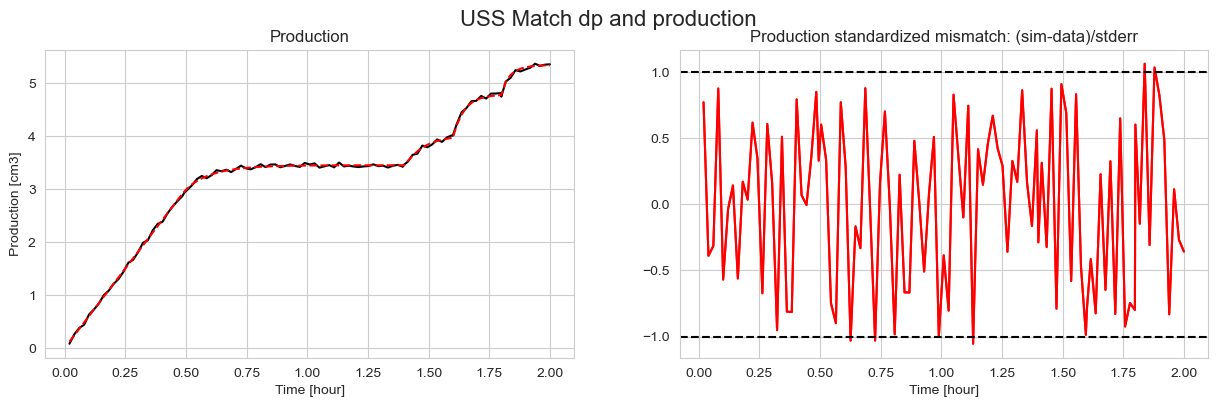

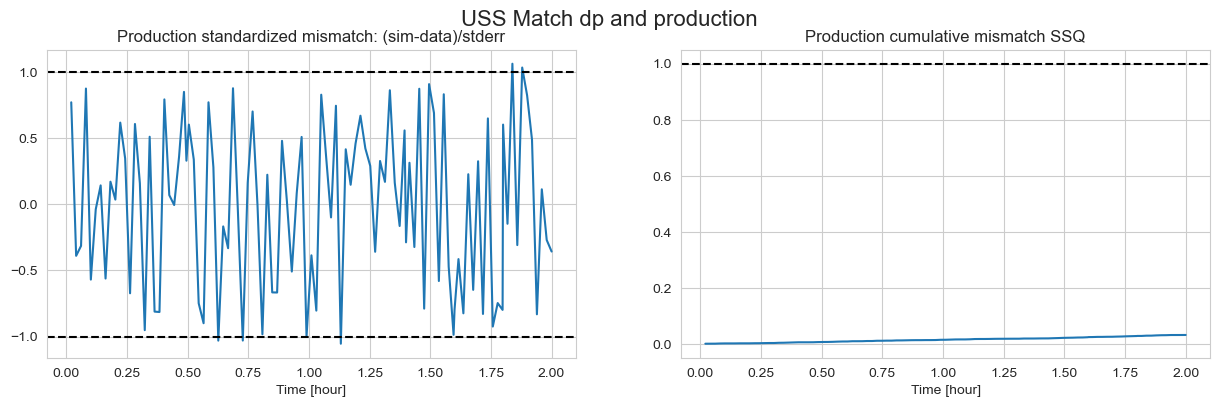

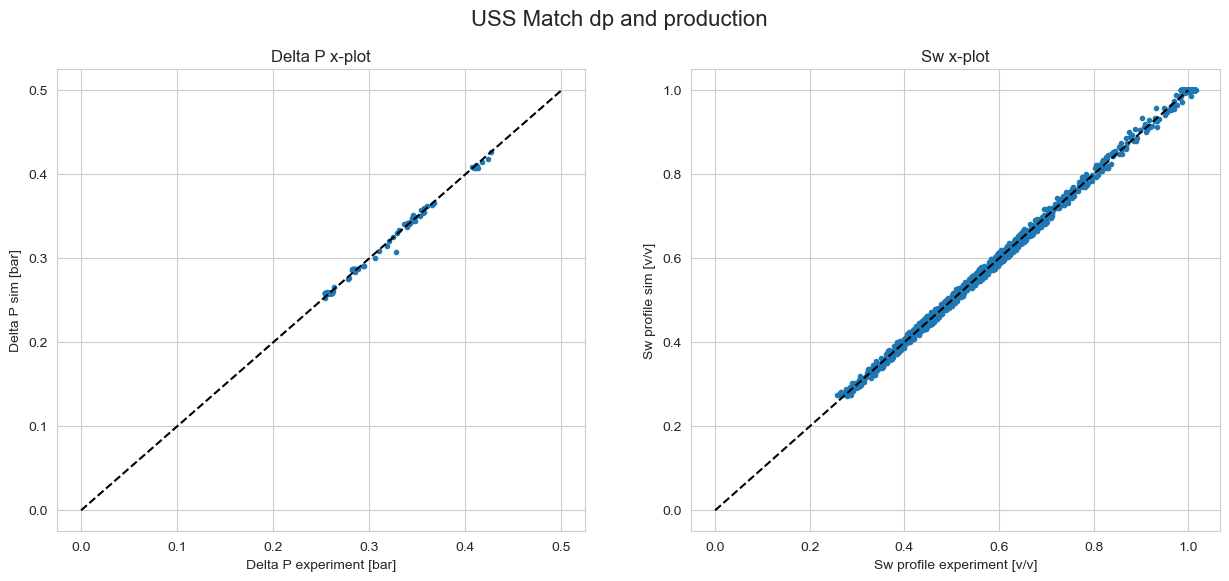

In [21]:
plot_match_all_uss(uss_matchobj,'USS Match dp and production')
#plot_match_all(uss_matchobj,'USS Match dp and production')

# Plot Saturation change along plug for each flooding period

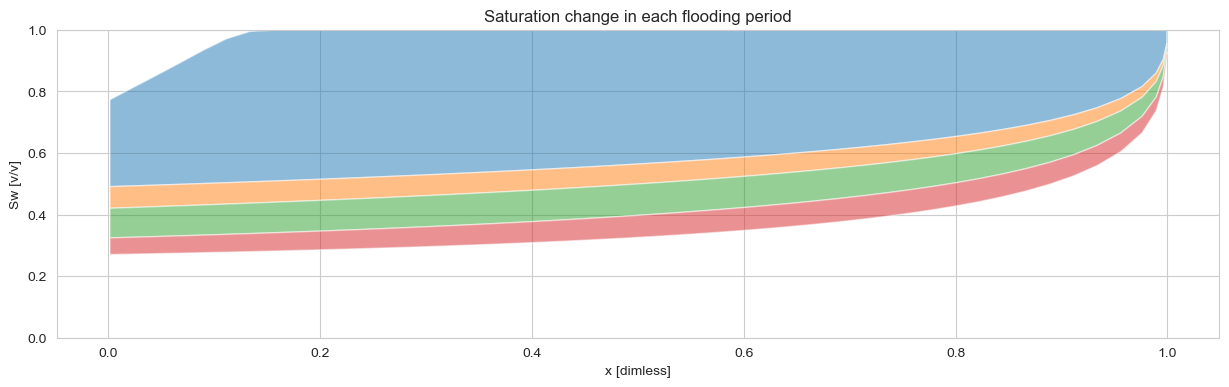

In [22]:
#Saturation change along plug for each flooding period

plt.figure(figsize=(15,4))

result1 = model1.results

lw = result1.movie_sw[0,:]
for i in range(1,result1.movie_period.max()+1):
    hg = result1.movie_sw[result1.movie_period==i][-1,:]
    plt.fill_between( result1.xD,lw,hg,alpha=0.5)
    lw = hg

plt.ylim(0,1);
plt.xlabel('x [dimless]')
plt.ylabel('Sw [v/v]');

plt.title('Saturation change in each flooding period');
plt.show()

# Plot match of saturation profiles

In [23]:
def get_sim_sw_profiles( model_result, his_profile_times, his_xD_position ):
    
    model_xD    = model_result.xD
    movie_time  = model_result.movie_time 
    movie_sw    = model_result.movie_sw
    
    # Identify which movie index corresponds to historical sample time
    time_index = [np.argmin( np.abs(v-movie_time) ) for v in his_profile_times]
    
    # Interpolate simulation sw at data position for each sample time
    sw_sim = []
    for i in time_index:
        swi = np.interp( his_xD_position, model_xD, movie_sw[i] )
        sw_sim.append(swi)   
    sw_sim = np.array( sw_sim )
    
    return sw_sim    
    
def get_his_sim_profiles( sw_profile_times, sw_profile_data, model_result ):
    
    xpos_his, sw_his = get_his_sw_profiles( sw_profile_data )
    
    # get simulated sw profiles at data sample locations and data sample times
    sw_sim = get_sim_sw_profiles( model_result, sw_profile_times, xpos_his )
    
    return xpos_his, sw_his, sw_sim

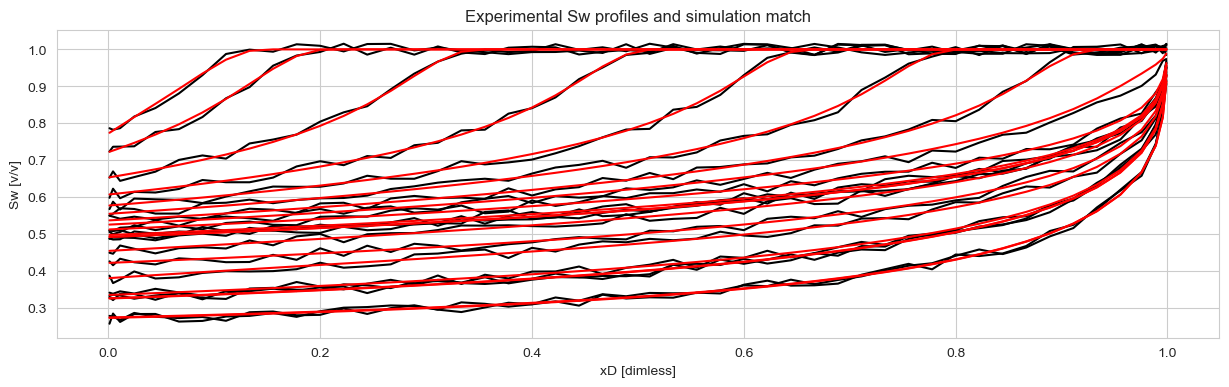

In [24]:
plt.figure(figsize=(15,4))
#plt.plot( result_exp.xD, Swproferr, color='gray',label='experimental data');
#plt.plot( result1.xD, result1.movie_sw.T, 'k',label='match');


for c in expdataHISsatprofiles.columns:
    if c.startswith('Profile'):
      plt.plot( expdataHISsatprofiles.xD, expdataHISsatprofiles[c].values, '-',color='black',label='experimental data');

#plt.plot( result1.xD, result1.movie_sw.T, 'r-',label='match');

for i in range(len(expdataHISsattimes)):
     plt.plot( get_his_sim_profiles(expdataHISsattimes,expdataHISsatprofiles,result1)[0],get_his_sim_profiles(expdataHISsattimes,expdataHISsatprofiles,result1)[2][i], 'r-',label='match');

plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Experimental Sw profiles and simulation match');
#plt.legend()
plt.show()

# Plot error ranges

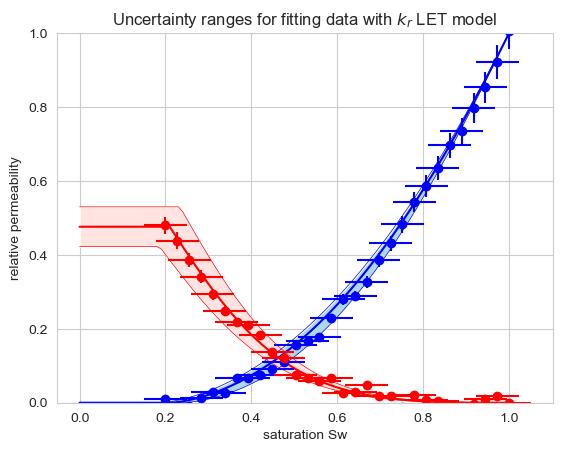

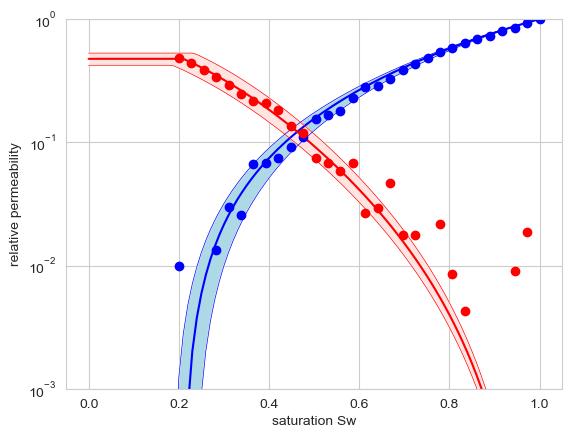

In [25]:
# error ranges for kr

LETnames=['Swc', 'Sorw', 'krwe', 'kroe', 'Lw', 'Ew', 'Tw', 'Lo', 'Eo', 'To']
errorsignw=[-1.0,  1.0,    1.0,    0.0,  -1.0,  -1.0,  1.0, 0.0,  0.0,  0.0]
errorsigno=[1.0, -1.0,    0.0,    1.0,  0.0,  0.0,  0.0, -1.0,  -1.0,  1.0]



result_LET=result_pckr
#result_LET.params.pretty_print()

LETfiterror = result_LET.params.copy()
LETfiterrorupw = LETfiterror.copy()
LETfiterrordownw = LETfiterror.copy()
LETfiterrorupo = LETfiterror.copy()
LETfiterrordowno = LETfiterror.copy()

for l in range(len(LETnames)):
    
    stderract = LETfiterror[LETnames[l]].stderr
    if stderract > np.abs(LETfiterror[LETnames[l]].max-LETfiterror[LETnames[l]].min):
       stderract = np.abs(LETfiterror[LETnames[l]].max-LETfiterror[LETnames[l]].min) 
       
    
    #if LETfiterror[LETnames[l]].value+stderract/2 > LETfiterror[LETnames[l]].max:
    #   stderract = 2*(LETfiterror[LETnames[l]].max-LETfiterror[LETnames[l]].value)
    #
    #if LETfiterror[LETnames[l]].value-stderract/2 < LETfiterror[LETnames[l]].min:
    #   stderract = 2*(LETfiterror[LETnames[l]].value-LETfiterror[LETnames[l]].min)
    
    
    LETfiterrorupw[LETnames[l]].value=LETfiterror[LETnames[l]].value+errorsignw[l]*stderract/2
    LETfiterrorupo[LETnames[l]].value=LETfiterror[LETnames[l]].value+errorsigno[l]*stderract/2
    LETfiterrordownw[LETnames[l]].value=LETfiterror[LETnames[l]].value-errorsignw[l]*stderract/2
    LETfiterrordowno[LETnames[l]].value=LETfiterror[LETnames[l]].value-errorsigno[l]*stderract/2
    
    if LETfiterrorupw[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrorupw[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrorupw[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrorupw[LETnames[l]].value = LETfiterror[LETnames[l]].min
        
    if LETfiterrorupo[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrorupo[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrorupo[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrorupo[LETnames[l]].value = LETfiterror[LETnames[l]].min
    
    if LETfiterrordownw[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrordownw[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrordownw[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrordownw[LETnames[l]].value = LETfiterror[LETnames[l]].min
        
    if LETfiterrordowno[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrordowno[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrordowno[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrordowno[LETnames[l]].value = LETfiterror[LETnames[l]].min
    
 

def params_to_rlpmodel(params ):
        v = params.valuesdict()
        Swc  = v['Swc']
        Sorw = v['Sorw']
        krwe = v['krwe']
        kroe = v['kroe']
        Lw   = v['Lw']
        Ew   = v['Ew']
        Tw   = v['Tw']
        Lo   = v['Lo']
        Eo   = v['Eo']
        To   = v['To']
        rlp_model = rlplib.Rlp2PLET( Swc, Sorw, Lw, Ew, Tw, 
                                     Lo, Eo, To, krwe, kroe)        
        return rlp_model

def params_to_cprmodel(params ):
        v = params.valuesdict()
        Swc  = v['Swc']
        Sorw = v['Sorw']
        Swi  = v['Swi']
        cwi  = v['cwi']
        awi  = v['awi']
        aoi  = v['aoi']
        ci   = v['ci']
        ofs  = v['ofs']
        # We take Sorw for Pc to the right of the relperm Sorw
        Sorwi = Sorw - 0.01
        skj_model = Skjaeveland( Swc, Sorwi, Swi, cwi, awi, aoi, ci, ofs )
        # We give the Skjaevland Pc model to the simulator as a cubic interpolation model
        EPS = 0.001
        n = 101
        swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )
        pcvi = skj_model.calc(swvi)
        cpr_model = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )
        return cpr_model


rlpmodel_LET_fit = params_to_rlpmodel(result_LET.params)
rlp_model3w = params_to_rlpmodel(LETfiterrorupw)
rlp_model3o = params_to_rlpmodel(LETfiterrorupo)
rlp_model4w = params_to_rlpmodel(LETfiterrordownw)
rlp_model4o = params_to_rlpmodel(LETfiterrordowno)

swv = np.linspace(0,1,101)
plt.figure()
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.plot( swv, rlp_model3w.calc_kr1(swv), 'b', linewidth=0.5, label='+stderr')
plt.plot( swv, rlp_model3o.calc_kr2(swv), 'r', linewidth=0.5, label='+stderr')
plt.plot( swv, rlp_model4w.calc_kr1(swv), 'b', linewidth=0.5, label='-stderr')
plt.plot( swv, rlp_model4o.calc_kr2(swv), 'r', linewidth=0.5, label='-stderr')
plt.fill_between( swv, rlp_model4w.calc_kr1(swv), rlp_model3w.calc_kr1(swv), facecolor='lightblue', interpolate=True)
plt.fill_between( swv, rlp_model4o.calc_kr2(swv), rlp_model3o.calc_kr2(swv), facecolor='mistyrose', interpolate=True)
#plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo')
plt.errorbar( Kr_data.Sat, Kr_data.kr1, xerr=0.05, yerr=np.abs(Kr_data.kr1*krerrlevel), fmt='o', color='blue', label='krw manual match')
#plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro');
plt.errorbar( Kr_data.Sat, Kr_data.kr2, xerr=0.05, yerr=np.abs(Kr_data.kr2*krerrlevel), fmt='o', color='red', label='kroo manual match')
plt.ylim(0,1)
#plt.legend();
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
plt.title('Uncertainty ranges for fitting data with $k_r$ LET model');
plt.show()

plt.semilogy( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.semilogy( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.semilogy( swv, rlp_model3w.calc_kr1(swv), 'b', linewidth=0.5, label='+stderr')
plt.semilogy( swv, rlp_model3o.calc_kr2(swv), 'r', linewidth=0.5, label='+stderr')
plt.semilogy( swv, rlp_model4w.calc_kr1(swv), 'b', linewidth=0.5, label='-stderr')
plt.semilogy( swv, rlp_model4o.calc_kr2(swv), 'r', linewidth=0.5, label='-stderr')
plt.fill_between( swv, rlp_model4w.calc_kr1(swv), rlp_model3w.calc_kr1(swv), facecolor='lightblue', interpolate=True)
plt.fill_between( swv, rlp_model4o.calc_kr2(swv), rlp_model3o.calc_kr2(swv), facecolor='mistyrose', interpolate=True)
plt.semilogy( Kr_data.Sat, Kr_data.kr1, 'bo')
#plt.errorbar( Kr_data.Sat, Kr_data.kr1, xerr=0.05, yerr=np.abs(Kr_data.kr1*0.1), fmt='o', color='blue', label='krw manual match')
plt.semilogy( Kr_data.Sat, Kr_data.kr2, 'ro');
#plt.errorbar( Kr_data.Sat, Kr_data.kr2, xerr=0.05, yerr=np.abs(Kr_data.kr2*0.1), fmt='o', color='red', label='kroo manual match')

plt.ylim(1E-3,1)
#plt.legend(); 
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
#plt.title('Best fit of LET relperms to tabulated kr');
plt.show()

## Alternative method for error ranges 
### by randomly selecting kr parameters within stdev of lmfit 
### and then plot +/- 1 stdev LET kr

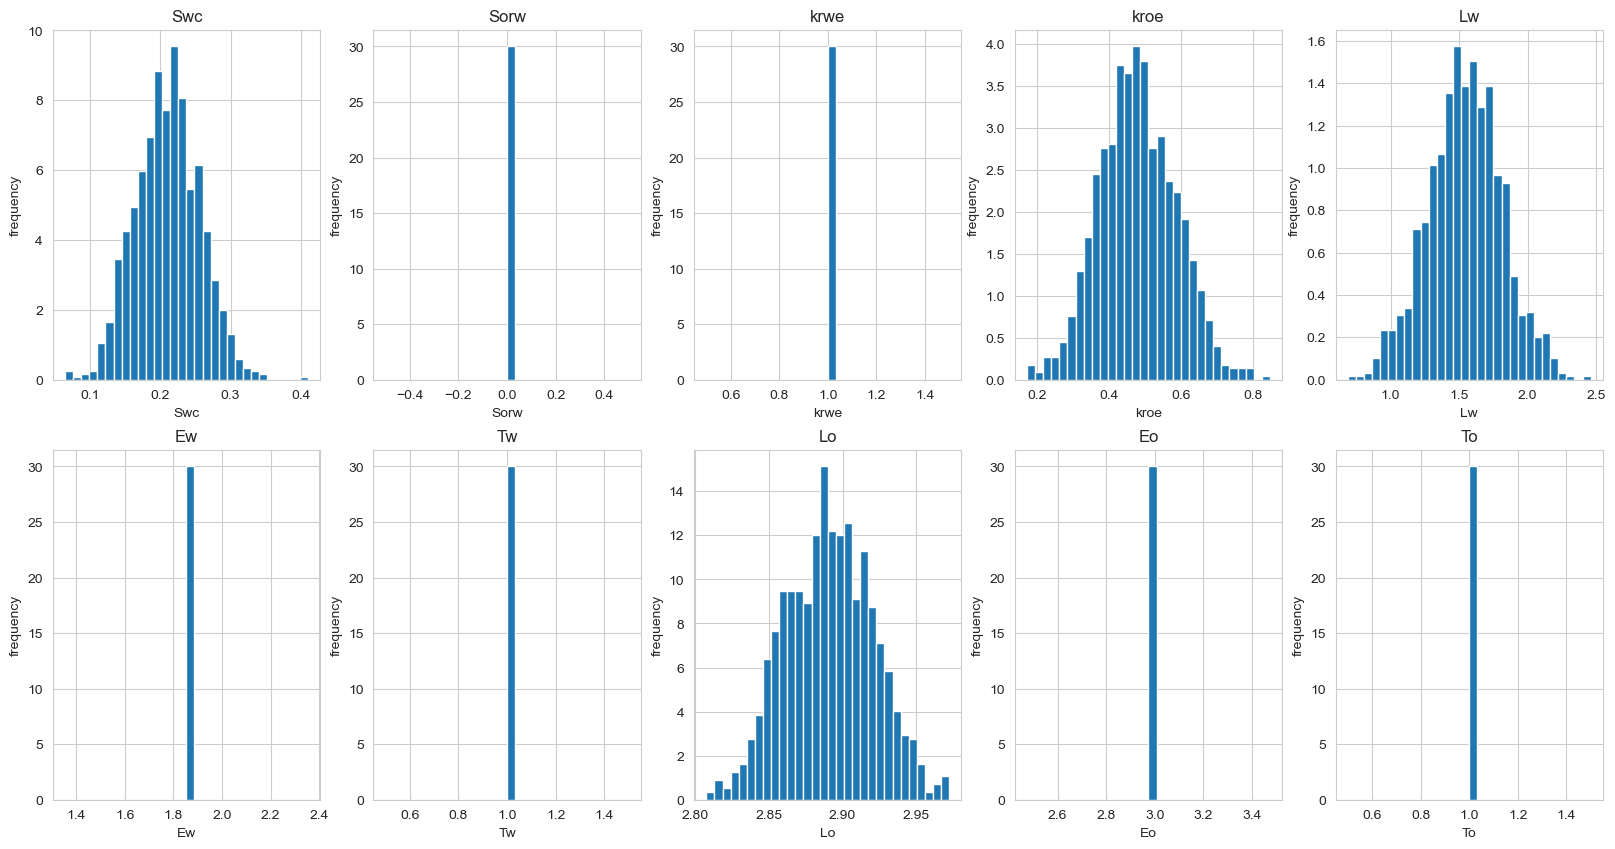

In [26]:
# Take random samples for each fit parameter +/- 1 stdev

LETfiterror = result_LET.params.copy()
ntraces = 1000     # samples per stdev range for each LET parameter

krerrmatrix = np.zeros((len(LETnames),ntraces))   # matrix for storing the error samples


np.random.seed(4123)
LETfiterroract = result_LET.params.copy()
for l in range(len(LETnames)):
          krerrmatrix[l]=np.random.normal(LETfiterror[LETnames[l]].value,LETfiterror[LETnames[l]].stderr, ntraces)       # sample from a normal distribution for each LET parameter within 1 stdev 


# plot histograms of the error samples
import math
i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(math.ceil(len(LETnames)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 10))
for n in range(len(LETnames)):
    axs[i][j].hist(krerrmatrix[n], 30, density=True)
    axs[i][j].set_ylabel('frequency')
    axs[i][j].set_xlabel(LETnames[n])
    axs[i][j].set_title(LETnames[n])
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

In [27]:
# next step: compute 1000 LET relperm curves from the 1000 samples for each LET parameter
# then compute average and stdev, and then plot range + / - 1 stdev

kr1matrix = np.zeros((len(swv),ntraces))   # matrix for storing the error samples
kr2matrix = np.zeros((len(swv),ntraces))   # matrix for storing the error samples

# the order of i and l seems to matter a lot
for i in range(0,ntraces-1):
      for l in range(len(LETnames)):
          LETfiterroract[LETnames[l]].value=krerrmatrix[l,i]
         
      rlpmodel_LET_fit_erract = params_to_rlpmodel(LETfiterroract)
      kr1matrix[:,i]=rlpmodel_LET_fit_erract.calc_kr1(swv)
      kr2matrix[:,i]=rlpmodel_LET_fit_erract.calc_kr2(swv)


kr1mean=np.mean(kr1matrix, axis=1)  # mean of the 1000 relperm curves
kr2mean=np.mean(kr2matrix, axis=1)  # mean of the 1000 relperm curves
kr1std=np.std(kr1matrix, axis=1)    # stdev of the 1000 relperm curves
kr2std=np.std(kr2matrix, axis=1)    # stdev of the 1000 relperm curves

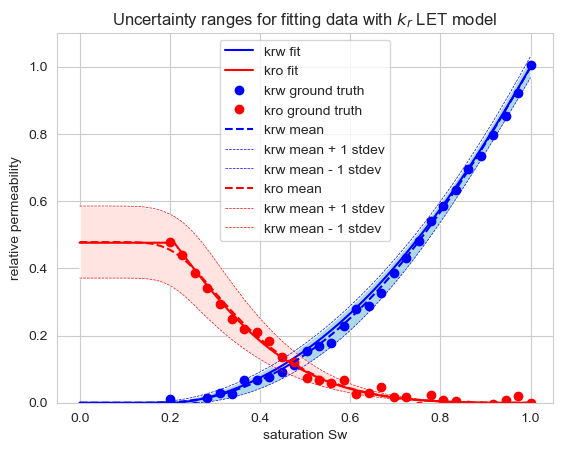

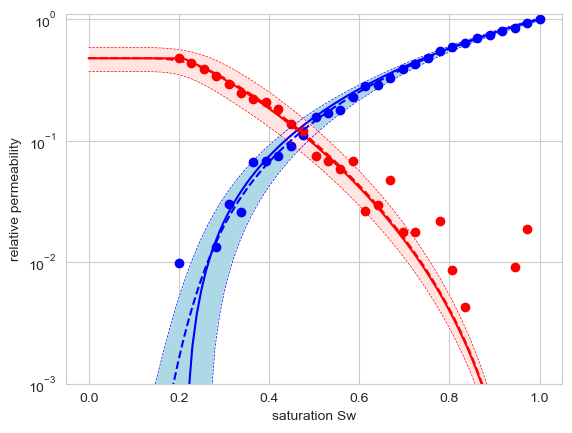

In [28]:
swv = np.linspace(0,1,101)

plt.figure()
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')

plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo',label='krw ground truth')
plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro',label='kro ground truth');

plt.plot( swv, kr1mean, 'b--', label='krw mean')
plt.plot( swv, kr1mean+1.0*kr1std, 'b--', linewidth=0.5, label='krw mean + 1 stdev')
plt.plot( swv, kr1mean-1.0*kr1std, 'b--', linewidth=0.5, label='krw mean - 1 stdev')
plt.fill_between( swv, kr1mean+1.0*kr1std, kr1mean-1.0*kr1std, facecolor='lightblue', interpolate=True)

plt.plot( swv, kr2mean, 'r--', label='kro mean')
plt.plot( swv, kr2mean+1.0*kr2std, 'r--', linewidth=0.5, label='krw mean + 1 stdev')
plt.plot( swv, kr2mean-1.0*kr2std, 'r--', linewidth=0.5, label='krw mean - 1 stdev')
plt.fill_between( swv, kr2mean+1.0*kr2std, kr2mean-1.0*kr2std, facecolor='mistyrose', interpolate=True)

plt.ylim(0,1.1)
plt.legend();
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
plt.title('Uncertainty ranges for fitting data with $k_r$ LET model');
plt.show()



plt.figure()
plt.semilogy( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.semilogy( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')

plt.semilogy( Kr_data.Sat, Kr_data.kr1, 'bo')
plt.semilogy( Kr_data.Sat, Kr_data.kr2, 'ro');

plt.semilogy( swv, kr1mean, 'b--', label='krw mean')
plt.semilogy( swv, kr1mean+1.0*kr1std, 'b--', linewidth=0.5, label='krw mean + 1 stdev')
plt.semilogy( swv, kr1mean-1.0*kr1std, 'b--', linewidth=0.5, label='krw mean - 1 stdev')
plt.fill_between( swv, kr1mean+1.0*kr1std, kr1mean-1.0*kr1std, facecolor='lightblue', interpolate=True)

plt.semilogy( swv, kr2mean, 'r--', label='kro mean')
plt.semilogy( swv, kr2mean+1.0*kr2std, 'r--', linewidth=0.5, label='krw mean + 1 stdev')
plt.semilogy( swv, kr2mean-1.0*kr2std, 'r--', linewidth=0.5, label='krw mean - 1 stdev')
plt.fill_between( swv, kr2mean+1.0*kr2std, kr2mean-1.0*kr2std, facecolor='mistyrose', interpolate=True)


plt.ylim(1E-3,1.1)
#plt.legend(); 
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
#plt.title('Best fit of LET relperms to tabulated kr');
plt.show()


## Uncertainty ranges for relperms and capillary pressure using covariance matrix
### Initialisation and random sampling

In [29]:
# compare number of LET parameters and size of covariance matrix
print('number of LET parameters = ', len(result_LET.params))
print('size of covariance matrix = ', len(result_LET.covar))

# mismatch is due to fixed parameters during minimization --> need to create new covariance matrix with all parameters and set the non-varied to 0

# make covariance matrix for all parameters
LETvary=[['Swc',0], ['Sorw',0], ['krwe',0], ['kroe',0], ['Lw',0], ['Ew',0], ['Tw',0], ['Lo',0], ['Eo',0], ['To',0],['Swi',0],['cwi',0],['awi',0],['aoi',0],['ci',0],['ofs',0]]

for i in range(len(LETvary)):
    if result_LET.params[LETvary[i][0]].vary==True:
         LETvary[i][1]=1
    else:
         LETvary[i][1]=0

# print(LETvary)

# make new covariance matrix of size len(LETvary) x len(LETvary)
covarmatrix = np.zeros((len(LETvary),len(LETvary)))              

#print('size of new covariance matrix = ', len(covarmatrix))

# transfer covariance matrix for varied parameters to new covariance matrix     
ci=0
cj=0
for i in range(len(LETvary)):
     if LETvary[i][1]==1:
        for j in range(len(LETvary)):
            if LETvary[j][1]==1:
               covarmatrix[i][j]=result_LET.covar[ci,cj]
               cj+=1
        cj=0
        ci+=1
               
#print(covarmatrix)

## Run iterations with new covariance matrix
# Number of traces
ntraces = 2500

# Initialize random number generator
rng = np.random.default_rng()

# Draw samples
samples_cov = rng.multivariate_normal(np.array([param.value for param in result_LET.params.values()]), covarmatrix, ntraces).T

# Remove parameter limits to allow for negative values now - then apply strict LET boundary conditions later.
for param in LETfiterroract.values():
    param.min = -np.inf
    param.max = np.inf

number of LET parameters =  16
size of covariance matrix =  10


### Uncertainty ranges for relperms

Error at iteration 0: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 2: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 3: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 4: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 7: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 8: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 9: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 11: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 13: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 18: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 19: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 23: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 24: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 25: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 26: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 29: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 31: Sr2 is negative, choose 0<=Sr2<1
Error at iteration 35: Sr2 is negative, choose 0<=Sr2<1

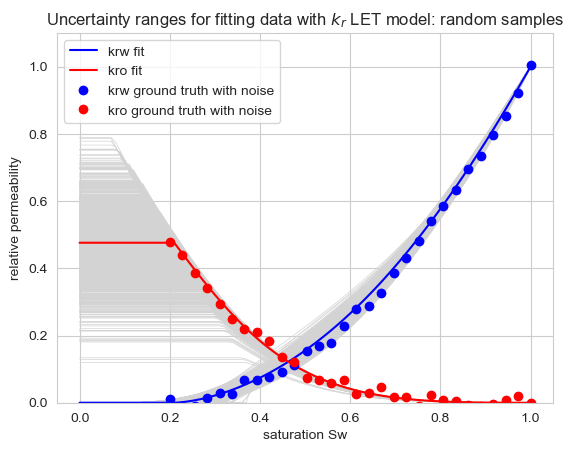

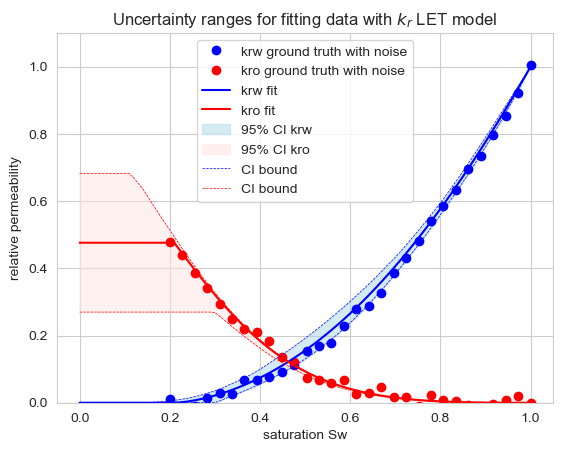

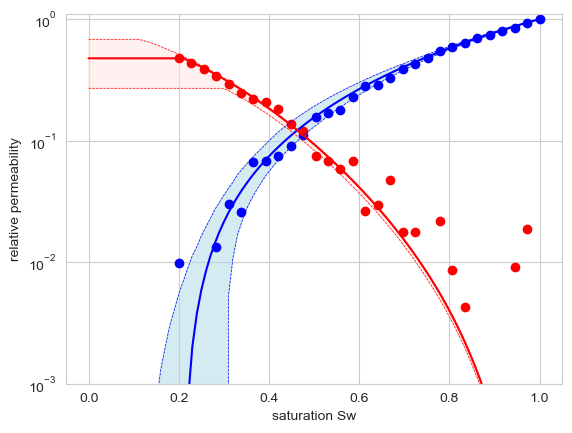

In [30]:
# Initialize arrays to store the relative permeability curves
swv = np.linspace(0,1,101)
curves_kr1 = np.zeros((ntraces, len(swv)))
curves_kr2 = np.zeros((ntraces, len(swv)))

# Loop over the samples
index_counter = 0
for i in range(ntraces):
    try:
        for l in range(len(LETnames)):
            LETfiterroract[LETnames[l]].value = samples_cov[l, i]

        rlpmodel_LET_fit_erract = params_to_rlpmodel(LETfiterroract)

        curves_kr1[index_counter, :] = rlpmodel_LET_fit_erract.calc_kr1(swv)
        curves_kr2[index_counter, :] = rlpmodel_LET_fit_erract.calc_kr2(swv)
        index_counter +=1
    except Exception as e:
        print(f"Error at iteration {i}: {e}")
        continue

# Remove unused rows
curves_kr1=curves_kr1[0:index_counter,:]
curves_kr2=curves_kr2[0:index_counter,:]

# Calculate the 2.5th and 97.5th percentiles
lower_kr1 = np.percentile(curves_kr1, 2.5, axis=0)
upper_kr1 = np.percentile(curves_kr1, 97.5, axis=0)
lower_kr2 = np.percentile(curves_kr2, 2.5, axis=0)
upper_kr2 = np.percentile(curves_kr2, 97.5, axis=0)

## Plotting
# Plot all traces with best fit
plt.figure()
for i in range(0,index_counter):
      plt.plot( swv, curves_kr1[i,:], '-', color='lightgrey',linewidth=0.5)
      plt.plot( swv, curves_kr2[i,:], '-', color='lightgrey',linewidth=0.5)
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')

plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo',label='krw ground truth with noise')
plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro', label='kro ground truth with noise')

plt.ylim(0,1.1)
plt.legend()
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
plt.title('Uncertainty ranges for fitting data with $k_r$ LET model: random samples')
plt.show()

# Plot shaded area of 95% confidence interval with best fit
plt.figure()
plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo',label='krw ground truth with noise')
plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro', label='kro ground truth with noise')
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.fill_between(swv, lower_kr1, upper_kr1, color='lightblue', alpha=0.5, label='95% CI krw')
plt.fill_between(swv, lower_kr2, upper_kr2, color='mistyrose', alpha=0.5, label='95% CI kro')
plt.plot( swv, upper_kr1, 'b--', linewidth=0.5, label='CI bound')
plt.plot( swv, lower_kr1, 'b--', linewidth=0.5, )
plt.plot( swv, upper_kr2, 'r--', linewidth=0.5, label='CI bound')
plt.plot( swv, lower_kr2, 'r--', linewidth=0.5, )
plt.xlabel('saturation Sw')
plt.ylabel('relative permeability')
plt.title('Uncertainty ranges for fitting data with $k_r$ LET model')
plt.legend()
plt.ylim(0, 1.1)
plt.show()

plt.figure()
plt.semilogy( Kr_data.Sat, Kr_data.kr1, 'bo')
plt.semilogy( Kr_data.Sat, Kr_data.kr2, 'ro')
plt.semilogy( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.semilogy( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.fill_between(swv, lower_kr1, upper_kr1, color='lightblue', alpha=0.5, label='95% CI krw')
plt.fill_between(swv, lower_kr2, upper_kr2, color='mistyrose', alpha=0.5, label='95% CI kro')
plt.semilogy( swv, upper_kr1, 'b--', linewidth=0.5, label='CI bound')
plt.semilogy( swv, lower_kr1, 'b--', linewidth=0.5, )
plt.semilogy( swv, upper_kr2, 'r--', linewidth=0.5, label='CI bound')
plt.semilogy( swv, lower_kr2, 'r--', linewidth=0.5, )
plt.ylim(1E-3,1.1)
# plt.legend()
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
# plt.title('Uncertainty ranges for fitting data with $k_r$ LET model')
plt.show()

### Uncertainty ranges for capillary pressure

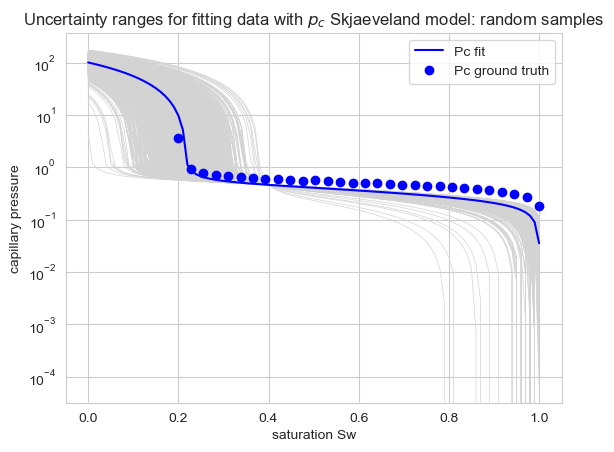

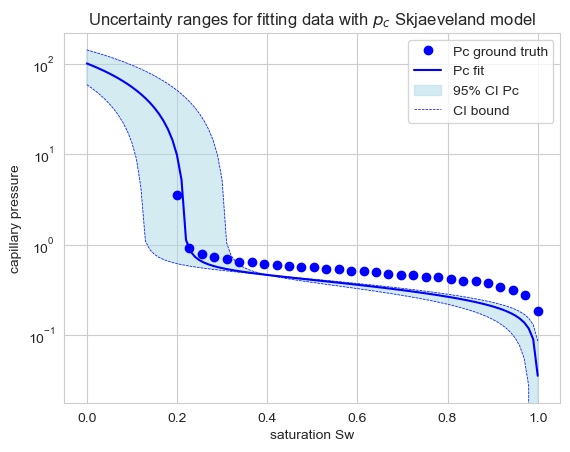

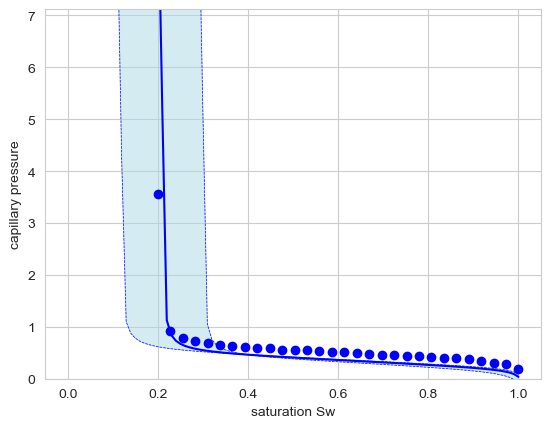

In [31]:
# Initialize array to store the capillary pressure curve
swv = np.linspace(0,1,101)

# Prevent divergence of Pc
swv_max = pcexp.Sat.max() + 0.01

curves_pc = np.zeros((ntraces, len(swv[swv<swv_max])))

# Loop over the samples
index_counter = 0
for i in range(ntraces):
    try:
        for l in range(len(LETnames)):
            LETfiterroract[LETnames[l]].value = samples_cov[l, i]

        # rlpmodel_LET_fit_erract = params_to_rlpmodel(LETfiterroract)
        cprmodel_LET_fit_erract = params_to_cprmodel(LETfiterroract)
        curves_pc[index_counter, :] = cprmodel_LET_fit_erract.calc(swv[swv<swv_max])[0]
        
        index_counter +=1
    except Exception as e:
        print(f"Error at iteration {i}: {e}")
        continue

# Remove unused rows
curves_pc=curves_pc[0:index_counter,:]

# Calculate the 2.5th and 97.5th percentiles
lower_pc = np.percentile(curves_pc, 2.5, axis=0)
upper_pc = np.percentile(curves_pc, 97.5, axis=0)

## Plotting
# Plot all traces with best fit
plt.figure()
for i in range(0,index_counter):
      plt.semilogy( swv[swv<swv_max], curves_pc[i,:], '-', color='lightgrey',linewidth=0.5)
cpr_model_LET_fit = params_to_cprmodel(result_LET.params)
plt.semilogy( swv[swv<swv_max], cpr_model_LET_fit.calc(swv[swv<swv_max])[0], 'b', label='Pc fit' )
plt.semilogy( pcexp.Sat, pcexp.Pc, 'bo', label='Pc ground truth')
# plt.ylim(0,1.1)
plt.legend()
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure')
plt.title('Uncertainty ranges for fitting data with $p_c$ Skjaeveland model: random samples')
plt.show()

plt.figure()
plt.semilogy( pcexp.Sat, pcexp.Pc, 'bo', label='Pc ground truth')
plt.semilogy( swv[swv<swv_max], cpr_model_LET_fit.calc(swv[swv<swv_max])[0], 'b', label='Pc fit' )
plt.fill_between(swv[swv<swv_max], lower_pc, upper_pc, color='lightblue', alpha=0.5, label='95% CI Pc')
plt.semilogy( swv[swv<swv_max], upper_pc, 'b--', linewidth=0.5, label='CI bound')
plt.semilogy( swv[swv<swv_max], lower_pc, 'b--', linewidth=0.5, )
# plt.ylim(1E-3,1.1)
plt.legend()
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure')
plt.title('Uncertainty ranges for fitting data with $p_c$ Skjaeveland model')
plt.show()

plt.figure()
plt.plot( pcexp.Sat, pcexp.Pc, 'bo', label='Pc ground truth')
plt.plot( swv[swv<swv_max], cpr_model_LET_fit.calc(swv[swv<swv_max])[0], 'b', label='Pc fit' )
plt.fill_between(swv[swv<swv_max], lower_pc, upper_pc, color='lightblue', alpha=0.5, label='95% CI Pc')
plt.plot( swv[swv<swv_max], upper_pc, 'b--', linewidth=0.5, label='CI bound')
plt.plot( swv[swv<swv_max], lower_pc, 'b--', linewidth=0.5, )
plt.ylim(0,2*np.max(pcexp.Pc))
# plt.legend()
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure')
# plt.title('Uncertainty ranges for fitting data with $p_c$ Skjaeveland model')
plt.show()

# Plot correlation matrix

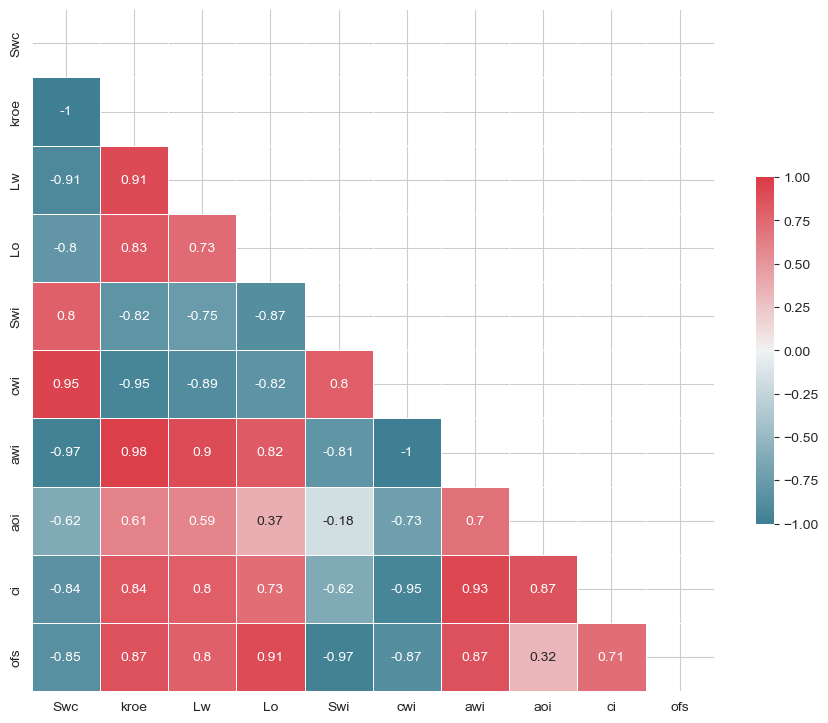

In [32]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


correlation=correlation_from_covariance(result_LET.covar)

#LETSKnames=['Swc', 'Sorw', 'krwe', 'kroe', 'Lw', 'Ew', 'Tw', 'Lo', 'Eo', 'To','Swi','cwi','awi','aoi','ci','ofs']  # all paramters
#LETSKnames=['Sorw', 'krwe', 'kroe', 'Lw', 'Lo', 'Swi', 'cwi','awi','aoi','ci','ofs']  #Swc=fixed                   # only varied parameters

LETSKnames=[]
# generate LETSKnames automatically 
for i in range (len(LETvary)):
    if LETvary[i][1]==1:
        LETSKnames.append(LETvary[i][0])

#corr = pd.DataFrame(data=correlation, index=LETnames, columns=LETnames)
corr = pd.DataFrame(data=correlation, index=LETSKnames, columns=LETSKnames)


# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=1.0,       # The maximum value of the legend. All higher vals will be same color
    vmin=-1.0,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

plt.show()